In [1]:
import numpy as np
import pandas as pd
import os
import surprise
import pickle

In [2]:
MOVIE_LENS_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'movie_lense'))
MOVIE_LENS_PATH

'/home/levin/escaping_echo_chambers/data/raw/movie_lense'

In [3]:
movielens = pd.read_csv(os.path.join(MOVIE_LENS_PATH, 'ratings.csv'))#.drop('timestamp', axis = 1)
# movielens = movielens[movielens.timestamp > (max(movielens['timestamp']) - 10*365*24*60*60)]
movielens = movielens.drop('timestamp', axis = 1)

In [4]:
movielens.shape

(27753444, 3)

In [5]:
movielens = movielens.rename(columns = {'userId':'uid', 'movieId':'iid', 'rating':'rating'})

In [6]:
genome_scores = pd.read_csv(os.path.join(MOVIE_LENS_PATH, 'genome-scores.csv'))

In [7]:
#Let's look at how many movies have genome tags
movies_with_genome = genome_scores['movieId'].unique()
print('# of movies with genome tags:', len(movies_with_genome))

# of movies with genome tags: 13176


In [8]:
#Total number
print('# of movies in total:', len(movielens['iid'].unique()))

# of movies in total: 53889


In [9]:
movielens_short = movielens[movielens.iid.isin(movies_with_genome)]

In [10]:
#Well, this does not really make it shorter:(
movielens_short.shape, movielens.shape

((27417362, 3), (27753444, 3))

In [11]:
movielens = movielens_short

In [12]:
# #Let's pick this user to explore the effect of echo chambers
# index_of_interest = 26841848
# movielens.loc[index_of_interest]

In [13]:
# #This user has this number of movies
# user_of_interest = movielens.loc[index_of_interest].uid
# print('The user_of_interest is uid {} and they have {} of movies'.format(user_of_interest, len(movielens[movielens.uid == user_of_interest])))
# # movielens[movielens.uid == 274053]

In [14]:
# row[26841848], row[26840745]

In [15]:
# #Let's find users similar to the user of interest under the euclidean distance
# #First, pivot the dataframe into a sparse matrix (it was so painful!)
# from scipy.sparse import csr_matrix
# from pandas.api.types import CategoricalDtype

# person_c = CategoricalDtype(sorted(movielens.uid.unique()), ordered=True)
# thing_c = CategoricalDtype(sorted(movielens.iid.unique()), ordered=True)

# row = movielens.uid.astype(person_c).cat.codes
# col = movielens.iid.astype(thing_c).cat.codes
# sparse_matrix = csr_matrix((movielens.rating, (row, col)), \
#                            shape=(person_c.categories.size, thing_c.categories.size))

In [16]:
# sparse_matrix.shape

In [17]:
# #Now let's find the closest k users
# k_users = 10000 #pick 30000
# from sklearn.metrics import pairwise_distances

# # user_distances = pairwise_distances(sparse_matrix, Y=sparse_matrix[row[26841848]], metric='euclidean', n_jobs=-1).reshape(-1,)
# #!!!! np.save('user_{}_dist.npy'.format(user_of_interest), user_distances)
# dist_indices = np.argsort(user_distances)

# #This is a way to find index of the row in the original movielens
# # i=10 
# # row[indices[i] == row].index[0] #i-th closest user index! #Multiple original rows correspond to that user, take the first, we need uid
# #These are the closest users, includes the user themselves
# closest_user_ids = [movielens.loc[row[dist_indices[i] == row].index[0]].uid for i in range(k_users)]

In [18]:
# movielens_similar = movielens[movielens.uid.isin(closest_user_ids)]

In [19]:
# movielens_similar.shape

In [12]:
n = 1000
np.random.seed(1)
sample_users = np.random.choice(movielens.uid.unique(), n)

In [13]:
movielens = movielens_short[movielens_short.uid.isin(sample_users)]

In [14]:
movielens.shape

(94157, 3)

In [45]:
pd.Series(movielens.iid.unique()).to_csv('movie-ids-in-the-system.csv')

In [15]:
lower_rating = movielens['rating'].min()
upper_rating = movielens['rating'].max()
print('Range:', lower_rating, upper_rating)

Range: 0.5 5.0


In [16]:
reader = surprise.Reader(rating_scale = (lower_rating, upper_rating))
data = surprise.Dataset.load_from_df(movielens, reader)

In [17]:
%%time
alg = surprise.SVD()
output = alg.fit(data.build_full_trainset())

CPU times: user 4.17 s, sys: 8.5 ms, total: 4.18 s
Wall time: 4.19 s


In [26]:
# param_grid = {'n_epochs': {10, 15, 20, 25, 30, 40}, 'lr_all': {0.01}, 'reg_all': {0.1}}
# gs = surprise.model_selection.GridSearchCV(surprise.SVD, param_grid, measures=['rmse', 'mae'], cv = 5, n_jobs=-1)
# gs.fit(data)
# print(gs.best_params['rmse'])
# print(gs.best_params['mae'])
# print(gs.best_score)
#Result n_epochs = 30 is enough

In [27]:
param_grid = {'n_epochs':{30},'lr_all' : {0.1, 0.001, 0.01, 0.005}, 'reg_all' : {0.02, .1, .5}}
gs = surprise.model_selection.GridSearchCV(surprise.SVD, param_grid, measures=['rmse', 'mae'], cv = 5, n_jobs=-1)
gs.fit(data)
print(gs.best_params['rmse'])
print(gs.best_params['mae'])
print(gs.best_score)

{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
{'rmse': 0.8866088011998731, 'mae': 0.676868899336516}


In [28]:
#Default:
param_grid = {'lr_all' : {0.005}, 'reg_all' : {0.02}}
gs = surprise.model_selection.GridSearchCV(surprise.SVD, param_grid, measures=['rmse', 'mae'], cv = 5, n_jobs=-1)
gs.fit(data)
print(gs.best_params['rmse'])
print(gs.best_params['mae'])
print(gs.best_score)

{'lr_all': 0.005, 'reg_all': 0.02}
{'lr_all': 0.005, 'reg_all': 0.02}
{'rmse': 0.9056273264532209, 'mae': 0.69268386426755}


In [26]:
data.df.shape

(94157, 3)

In [63]:
recommend(50, data, alg, top_n = 15)

(array([ 318, 1203,   50, 2019, 1193, 5618,  541,  858,  908,  904, 1234,
        1276, 2324, 2959, 1250]),
 array([4.56340869, 4.54125474, 4.53315701, 4.50889273, 4.50736983,
        4.50272784, 4.49714948, 4.490778  , 4.47540228, 4.46950693,
        4.46895292, 4.46754734, 4.46553675, 4.46436385, 4.45482249]),
     uid   iid    rating
 0    50   318  4.563409
 1    50  1203  4.541255
 2    50    50  4.533157
 3    50  2019  4.508893
 4    50  1193  4.507370
 5    50  5618  4.502728
 6    50   541  4.497149
 7    50   858  4.490778
 8    50   908  4.475402
 9    50   904  4.469507
 10   50  1234  4.468953
 11   50  1276  4.467547
 12   50  2324  4.465537
 13   50  2959  4.464364
 14   50  1250  4.454822)

In [18]:
def recommend(uid, data, model, top_n = 100):
    all_movie_ids = data.df['iid'].unique()
    uid_rated = data.df[data.df['uid'] == uid]['iid']
    movies_to_recommend = np.setdiff1d(all_movie_ids, uid_rated)
    prediction_set = [[uid, iid, 0] for iid in movies_to_recommend] #here 0 is arbitrary, ratings don't matter
    predictions = model.test(prediction_set)
    pred_ratings = np.array([pred.est for pred in predictions])
    top = pred_ratings.argsort()[::-1][:top_n]
    data_update = pd.DataFrame([[uid, movies_to_recommend[top][i], pred_ratings[top][i]] for i in range(top_n)], columns = ['uid', 'iid', 'rating'])
    return movies_to_recommend[top], pred_ratings[top], data_update#len(movies_to_recommend), len(all_movie_ids) 

In [28]:
# def recommend(uid, data, model, top_n = 100):
#     all_movie_ids = data.df['iid'].unique()
#     uid_rated = data.df[data.df['uid'] == uid]['iid']
#     movies_to_recommend = np.setdiff1d(all_movie_ids, uid_rated)
#     prediction_set = [[uid, iid, 0] for iid in movies_to_recommend] #here 0 is arbitrary, ratings don't matter
#     predictions = model.test(prediction_set)
#     pred_ratings = np.array([pred.est for pred in predictions])
#     top = pred_ratings.argsort()[::-1][:top_n]
#     data_update = pd.DataFrame([[uid, movies_to_recommend[top][i], pred_ratings[top][i]] for i in range(top_n)], columns = ['uid', 'iid', 'rating'])
#     return movies_to_recommend[top], pred_ratings[top], data_update#len(movies_to_recommend), len(all_movie_ids) 

In [19]:
from tqdm import tqdm
import time


def simulate(alg, data, sample_users, n_epochs = 10, top_n = 15, lower_rating = 0.5, upper_rating = 5.0):
    #Note that data changes inplace!
    evolution_of_movies = []
    evolution_of_ratings = []
    #First prediction
    for epoch in tqdm(range(n_epochs)):
        print('Epoch #{}'.format(epoch))
        user_top_matrix_per_epoch = []
        user_top_rating_matrix_per_epoch = []
        start_fit = time.time()
        print('Shape of the data:', data.df.shape)
        model = alg.fit(data.build_full_trainset())
        end_fit = time.time()
        print('    Fit took {} seconds'.format(end_fit-start_fit))
        #Recommend for everyone
        data_new = data.df.copy()
        start_predict = time.time()
        for uid in sample_users:
            iid_recommended, ratings_recommended, data_update = recommend(uid, data, model, top_n = top_n)
            user_top_matrix_per_epoch.append(iid_recommended)
            user_top_rating_matrix_per_epoch.append(ratings_recommended)
#             print(data_new.columns, data_update.columns)
            data_new = data_new.append([data_update]).reset_index(drop = True)
#             print(data_new.shape)
        end_predict = time.time()
        print('    Predict took {} seconds'.format(end_predict-start_predict))
        user_top_df_per_epoch = pd.DataFrame(user_top_matrix_per_epoch, index = ['uid_{}'.format(i) for i in sample_users], 
                     columns = ['top_'+str(i+1) for i in range(top_n)])
        user_top_rating_df_per_epoch = pd.DataFrame(user_top_rating_matrix_per_epoch, index = ['uid_{}'.format(i) for i in sample_users], 
                     columns = ['top_'+str(i+1) for i in range(top_n)])
        evolution_of_movies.append(user_top_df_per_epoch)
        evolution_of_ratings.append(user_top_rating_df_per_epoch)
        print('Evolution of movies and ratings appended')
        start_update_data = time.time()
        reader = surprise.Reader(rating_scale = (lower_rating, upper_rating))
        data = surprise.Dataset.load_from_df(data_new, reader)
        end_update_data = time.time()
        print('    Update_data took {} seconds'.format(end_update_data-start_update_data))
        print('Shape:', data.df.shape)
    return evolution_of_movies, evolution_of_ratings

In [20]:
len(data.df.iid.unique())

8116

In [36]:
np.argmax([len(data.df[data.df.uid == i]) for i in sample_users[:50]])

21

In [37]:
sample_users[21]

117610

In [33]:
%%time
alg = surprise.SVD()#surprise.SVD(n_epochs=30, lr_all=0.01, reg_all=0.1)#surprise.SVD()
evolution_of_movies, evolution_of_ratings = simulate(alg, data, sample_users[:50], n_epochs = 99, top_n = 70)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch #0
Shape of the data: (94157, 3)
    Fit took 3.9510271549224854 seconds


  1%|          | 1/99 [00:07<12:09,  7.45s/it]

    Predict took 3.3673770427703857 seconds
Evolution of movies and ratings appended
    Update_data took 0.12029433250427246 seconds
Shape: (97657, 3)
Epoch #1
Shape of the data: (97657, 3)
    Fit took 4.424938201904297 seconds


  2%|▏         | 2/99 [00:15<12:19,  7.63s/it]

    Predict took 3.531161069869995 seconds
Evolution of movies and ratings appended
    Update_data took 0.08078551292419434 seconds
Shape: (101157, 3)
Epoch #2
Shape of the data: (101157, 3)
    Fit took 4.627948760986328 seconds


  3%|▎         | 3/99 [00:23<12:18,  7.69s/it]

    Predict took 3.124268054962158 seconds
Evolution of movies and ratings appended
    Update_data took 0.07359910011291504 seconds
Shape: (104657, 3)
Epoch #3
Shape of the data: (104657, 3)
    Fit took 4.403502464294434 seconds


  4%|▍         | 4/99 [00:30<12:08,  7.67s/it]

    Predict took 3.079301595687866 seconds
Evolution of movies and ratings appended
    Update_data took 0.12858343124389648 seconds
Shape: (108157, 3)
Epoch #4
Shape of the data: (108157, 3)
    Fit took 4.531994342803955 seconds


  5%|▌         | 5/99 [00:38<12:03,  7.69s/it]

    Predict took 3.076951503753662 seconds
Evolution of movies and ratings appended
    Update_data took 0.13135457038879395 seconds
Shape: (111657, 3)
Epoch #5
Shape of the data: (111657, 3)
    Fit took 4.856353044509888 seconds


  6%|▌         | 6/99 [00:47<12:12,  7.88s/it]

    Predict took 3.303955078125 seconds
Evolution of movies and ratings appended
    Update_data took 0.13658833503723145 seconds
Shape: (115157, 3)
Epoch #6
Shape of the data: (115157, 3)
    Fit took 4.85160231590271 seconds


  7%|▋         | 7/99 [00:55<12:10,  7.94s/it]

    Predict took 3.0836541652679443 seconds
Evolution of movies and ratings appended
    Update_data took 0.13704776763916016 seconds
Shape: (118657, 3)
Epoch #7
Shape of the data: (118657, 3)
    Fit took 5.007855176925659 seconds


  8%|▊         | 8/99 [01:03<12:09,  8.02s/it]

    Predict took 3.103663921356201 seconds
Evolution of movies and ratings appended
    Update_data took 0.08642768859863281 seconds
Shape: (122157, 3)
Epoch #8
Shape of the data: (122157, 3)
    Fit took 5.511868476867676 seconds


  9%|▉         | 9/99 [01:13<13:03,  8.71s/it]

    Predict took 4.692469358444214 seconds
Evolution of movies and ratings appended
    Update_data took 0.09801101684570312 seconds
Shape: (125657, 3)
Epoch #9
Shape of the data: (125657, 3)
    Fit took 5.876948833465576 seconds


 10%|█         | 10/99 [01:22<13:10,  8.88s/it]

    Predict took 3.284740447998047 seconds
Evolution of movies and ratings appended
    Update_data took 0.09951519966125488 seconds
Shape: (129157, 3)
Epoch #10
Shape of the data: (129157, 3)
    Fit took 7.283078670501709 seconds


 11%|█         | 11/99 [01:33<13:44,  9.37s/it]

    Predict took 3.138504981994629 seconds
Evolution of movies and ratings appended
    Update_data took 0.10059165954589844 seconds
Shape: (132657, 3)
Epoch #11
Shape of the data: (132657, 3)
    Fit took 5.823408365249634 seconds


 12%|█▏        | 12/99 [01:42<13:26,  9.27s/it]

    Predict took 3.1085972785949707 seconds
Evolution of movies and ratings appended
    Update_data took 0.0953981876373291 seconds
Shape: (136157, 3)
Epoch #12
Shape of the data: (136157, 3)
    Fit took 5.6386895179748535 seconds


 13%|█▎        | 13/99 [01:51<13:04,  9.13s/it]

    Predict took 3.039841890335083 seconds
Evolution of movies and ratings appended
    Update_data took 0.0981302261352539 seconds
Shape: (139657, 3)
Epoch #13
Shape of the data: (139657, 3)
    Fit took 5.836117744445801 seconds


 14%|█▍        | 14/99 [02:00<12:51,  9.07s/it]

    Predict took 2.999074935913086 seconds
Evolution of movies and ratings appended
    Update_data took 0.10109710693359375 seconds
Shape: (143157, 3)
Epoch #14
Shape of the data: (143157, 3)
    Fit took 5.930823087692261 seconds


 15%|█▌        | 15/99 [02:09<12:40,  9.05s/it]

    Predict took 2.892364978790283 seconds
Evolution of movies and ratings appended
    Update_data took 0.16089296340942383 seconds
Shape: (146657, 3)
Epoch #15
Shape of the data: (146657, 3)
    Fit took 6.509381055831909 seconds


 16%|█▌        | 16/99 [02:18<12:47,  9.24s/it]

    Predict took 3.0060360431671143 seconds
Evolution of movies and ratings appended
    Update_data took 0.1775350570678711 seconds
Shape: (150157, 3)
Epoch #16
Shape of the data: (150157, 3)
    Fit took 6.590822458267212 seconds


 17%|█▋        | 17/99 [02:28<12:46,  9.35s/it]

    Predict took 2.9003868103027344 seconds
Evolution of movies and ratings appended
    Update_data took 0.10543680191040039 seconds
Shape: (153657, 3)
Epoch #17
Shape of the data: (153657, 3)
    Fit took 6.520910263061523 seconds


 18%|█▊        | 18/99 [02:38<12:44,  9.44s/it]

    Predict took 2.9813008308410645 seconds
Evolution of movies and ratings appended
    Update_data took 0.11897730827331543 seconds
Shape: (157157, 3)
Epoch #18
Shape of the data: (157157, 3)
    Fit took 6.73040509223938 seconds


 19%|█▉        | 19/99 [02:47<12:45,  9.56s/it]

    Predict took 3.0001556873321533 seconds
Evolution of movies and ratings appended
    Update_data took 0.12307381629943848 seconds
Shape: (160657, 3)
Epoch #19
Shape of the data: (160657, 3)
    Fit took 7.240429162979126 seconds


 20%|██        | 20/99 [02:58<12:57,  9.84s/it]

    Predict took 3.091555118560791 seconds
Evolution of movies and ratings appended
    Update_data took 0.13135743141174316 seconds
Shape: (164157, 3)
Epoch #20
Shape of the data: (164157, 3)
    Fit took 7.418382406234741 seconds


 21%|██        | 21/99 [03:09<13:03, 10.05s/it]

    Predict took 2.9861927032470703 seconds
Evolution of movies and ratings appended
    Update_data took 0.12801289558410645 seconds
Shape: (167657, 3)
Epoch #21
Shape of the data: (167657, 3)
    Fit took 7.320459365844727 seconds


 22%|██▏       | 22/99 [03:19<13:04, 10.19s/it]

    Predict took 3.0586936473846436 seconds
Evolution of movies and ratings appended
    Update_data took 0.12801098823547363 seconds
Shape: (171157, 3)
Epoch #22
Shape of the data: (171157, 3)
    Fit took 7.684788703918457 seconds


 23%|██▎       | 23/99 [03:30<13:10, 10.40s/it]

    Predict took 3.0112056732177734 seconds
Evolution of movies and ratings appended
    Update_data took 0.18825006484985352 seconds
Shape: (174657, 3)
Epoch #23
Shape of the data: (174657, 3)
    Fit took 7.402208566665649 seconds


 24%|██▍       | 24/99 [03:40<13:03, 10.44s/it]

    Predict took 2.9314303398132324 seconds
Evolution of movies and ratings appended
    Update_data took 0.18961572647094727 seconds
Shape: (178157, 3)
Epoch #24
Shape of the data: (178157, 3)
    Fit took 8.09326434135437 seconds
    Predict took 3.0127475261688232 seconds
Evolution of movies and ratings appended


 25%|██▌       | 25/99 [03:52<13:12, 10.70s/it]

    Update_data took 0.20137524604797363 seconds
Shape: (181657, 3)
Epoch #25
Shape of the data: (181657, 3)
    Fit took 8.235572338104248 seconds


 26%|██▋       | 26/99 [04:03<13:16, 10.91s/it]

    Predict took 2.9855997562408447 seconds
Evolution of movies and ratings appended
    Update_data took 0.15494179725646973 seconds
Shape: (185157, 3)
Epoch #26
Shape of the data: (185157, 3)
    Fit took 8.435424566268921 seconds


 27%|██▋       | 27/99 [04:15<13:17, 11.07s/it]

    Predict took 2.869049549102783 seconds
Evolution of movies and ratings appended
    Update_data took 0.13327264785766602 seconds
Shape: (188657, 3)
Epoch #27
Shape of the data: (188657, 3)
    Fit took 7.8417792320251465 seconds


 28%|██▊       | 28/99 [04:25<12:59, 10.98s/it]

    Predict took 2.7042267322540283 seconds
Evolution of movies and ratings appended
    Update_data took 0.19578051567077637 seconds
Shape: (192157, 3)
Epoch #28
Shape of the data: (192157, 3)
    Fit took 8.468966722488403 seconds


 29%|██▉       | 29/99 [04:37<12:55, 11.08s/it]

    Predict took 2.714120864868164 seconds
Evolution of movies and ratings appended
    Update_data took 0.14474058151245117 seconds
Shape: (195657, 3)
Epoch #29
Shape of the data: (195657, 3)
    Fit took 8.445637226104736 seconds


 30%|███       | 30/99 [04:48<12:50, 11.16s/it]

    Predict took 2.7508480548858643 seconds
Evolution of movies and ratings appended
    Update_data took 0.14072561264038086 seconds
Shape: (199157, 3)
Epoch #30
Shape of the data: (199157, 3)
    Fit took 8.586987972259521 seconds


 31%|███▏      | 31/99 [04:59<12:43, 11.23s/it]

    Predict took 2.6543984413146973 seconds
Evolution of movies and ratings appended
    Update_data took 0.14539408683776855 seconds
Shape: (202657, 3)
Epoch #31
Shape of the data: (202657, 3)
    Fit took 8.395891666412354 seconds
    Predict took 2.554579019546509 seconds
Evolution of movies and ratings appended


 32%|███▏      | 32/99 [05:11<12:31, 11.21s/it]

    Update_data took 0.2069849967956543 seconds
Shape: (206157, 3)
Epoch #32
Shape of the data: (206157, 3)
    Fit took 8.754921674728394 seconds
    Predict took 2.5491952896118164 seconds
Evolution of movies and ratings appended


 33%|███▎      | 33/99 [05:22<12:26, 11.31s/it]

    Update_data took 0.21247243881225586 seconds
Shape: (209657, 3)
Epoch #33
Shape of the data: (209657, 3)
    Fit took 8.729199171066284 seconds


 34%|███▍      | 34/99 [05:34<12:16, 11.34s/it]

    Predict took 2.5091490745544434 seconds
Evolution of movies and ratings appended
    Update_data took 0.15518879890441895 seconds
Shape: (213157, 3)
Epoch #34
Shape of the data: (213157, 3)
    Fit took 9.341030359268188 seconds


 35%|███▌      | 35/99 [05:46<12:20, 11.56s/it]

    Predict took 2.5876641273498535 seconds
Evolution of movies and ratings appended
    Update_data took 0.15179204940795898 seconds
Shape: (216657, 3)
Epoch #35
Shape of the data: (216657, 3)
    Fit took 9.564248323440552 seconds


 36%|███▋      | 36/99 [05:58<12:24, 11.82s/it]

    Predict took 2.656799077987671 seconds
Evolution of movies and ratings appended
    Update_data took 0.17719244956970215 seconds
Shape: (220157, 3)
Epoch #36
Shape of the data: (220157, 3)
    Fit took 10.025864362716675 seconds


 37%|███▋      | 37/99 [06:11<12:28, 12.07s/it]

    Predict took 2.4768927097320557 seconds
Evolution of movies and ratings appended
    Update_data took 0.1531226634979248 seconds
Shape: (223657, 3)
Epoch #37
Shape of the data: (223657, 3)
    Fit took 9.709589004516602 seconds


 38%|███▊      | 38/99 [06:23<12:23, 12.18s/it]

    Predict took 2.5333635807037354 seconds
Evolution of movies and ratings appended
    Update_data took 0.1825428009033203 seconds
Shape: (227157, 3)
Epoch #38
Shape of the data: (227157, 3)
    Fit took 9.662496089935303 seconds


 39%|███▉      | 39/99 [06:36<12:14, 12.25s/it]

    Predict took 2.5384180545806885 seconds
Evolution of movies and ratings appended
    Update_data took 0.18611741065979004 seconds
Shape: (230657, 3)
Epoch #39
Shape of the data: (230657, 3)
    Fit took 9.652727842330933 seconds


 40%|████      | 40/99 [06:48<12:02, 12.25s/it]

    Predict took 2.4295077323913574 seconds
Evolution of movies and ratings appended
    Update_data took 0.16752314567565918 seconds
Shape: (234157, 3)
Epoch #40
Shape of the data: (234157, 3)
    Fit took 9.77208137512207 seconds
    Predict took 2.3369529247283936 seconds
Evolution of movies and ratings appended


 41%|████▏     | 41/99 [07:00<11:52, 12.28s/it]

    Update_data took 0.23471307754516602 seconds
Shape: (237657, 3)
Epoch #41
Shape of the data: (237657, 3)
    Fit took 10.247631072998047 seconds
    Predict took 2.552023410797119 seconds
Evolution of movies and ratings appended


 42%|████▏     | 42/99 [07:13<11:54, 12.53s/it]

    Update_data took 0.2942948341369629 seconds
Shape: (241157, 3)
Epoch #42
Shape of the data: (241157, 3)
    Fit took 11.145125389099121 seconds
    Predict took 2.334127426147461 seconds
Evolution of movies and ratings appended


 43%|████▎     | 43/99 [07:27<12:01, 12.89s/it]

    Update_data took 0.2469336986541748 seconds
Shape: (244657, 3)
Epoch #43
Shape of the data: (244657, 3)
    Fit took 10.882505178451538 seconds


 44%|████▍     | 44/99 [07:41<11:59, 13.09s/it]

    Predict took 2.4753777980804443 seconds
Evolution of movies and ratings appended
    Update_data took 0.17598176002502441 seconds
Shape: (248157, 3)
Epoch #44
Shape of the data: (248157, 3)
    Fit took 10.986206769943237 seconds


 45%|████▌     | 45/99 [07:54<11:52, 13.20s/it]

    Predict took 2.278630018234253 seconds
Evolution of movies and ratings appended
    Update_data took 0.17349743843078613 seconds
Shape: (251657, 3)
Epoch #45
Shape of the data: (251657, 3)
    Fit took 11.476158142089844 seconds


 46%|████▋     | 46/99 [08:08<11:51, 13.43s/it]

    Predict took 2.3061676025390625 seconds
Evolution of movies and ratings appended
    Update_data took 0.17966675758361816 seconds
Shape: (255157, 3)
Epoch #46
Shape of the data: (255157, 3)
    Fit took 11.38467001914978 seconds
    Predict took 2.321455240249634 seconds
Evolution of movies and ratings appended


 47%|████▋     | 47/99 [08:22<11:46, 13.59s/it]

    Update_data took 0.2583885192871094 seconds
Shape: (258657, 3)
Epoch #47
Shape of the data: (258657, 3)
    Fit took 11.63623046875 seconds
    Predict took 2.3514389991760254 seconds
Evolution of movies and ratings appended


 48%|████▊     | 48/99 [08:36<11:43, 13.79s/it]

    Update_data took 0.2641031742095947 seconds
Shape: (262157, 3)
Epoch #48
Shape of the data: (262157, 3)
    Fit took 11.674353837966919 seconds
    Predict took 2.29375958442688 seconds
Evolution of movies and ratings appended


 49%|████▉     | 49/99 [08:50<11:36, 13.93s/it]

    Update_data took 0.26992201805114746 seconds
Shape: (265657, 3)
Epoch #49
Shape of the data: (265657, 3)
    Fit took 11.92695426940918 seconds
    Predict took 2.2815639972686768 seconds
Evolution of movies and ratings appended


 51%|█████     | 50/99 [09:05<11:30, 14.10s/it]

    Update_data took 0.2717411518096924 seconds
Shape: (269157, 3)
Epoch #50
Shape of the data: (269157, 3)
    Fit took 11.558470010757446 seconds
    Predict took 2.120291233062744 seconds
Evolution of movies and ratings appended


 52%|█████▏    | 51/99 [09:19<11:14, 14.05s/it]

    Update_data took 0.2610640525817871 seconds
Shape: (272657, 3)
Epoch #51
Shape of the data: (272657, 3)
    Fit took 11.52759575843811 seconds
    Predict took 2.3342230319976807 seconds
Evolution of movies and ratings appended


 53%|█████▎    | 52/99 [09:33<11:00, 14.06s/it]

    Update_data took 0.2126154899597168 seconds
Shape: (276157, 3)
Epoch #52
Shape of the data: (276157, 3)
    Fit took 13.299183368682861 seconds
    Predict took 2.1414058208465576 seconds
Evolution of movies and ratings appended


 54%|█████▎    | 53/99 [09:49<11:08, 14.54s/it]

    Update_data took 0.2010786533355713 seconds
Shape: (279657, 3)
Epoch #53
Shape of the data: (279657, 3)
    Fit took 12.285040140151978 seconds
    Predict took 2.2102913856506348 seconds
Evolution of movies and ratings appended


 55%|█████▍    | 54/99 [10:03<10:57, 14.62s/it]

    Update_data took 0.2978813648223877 seconds
Shape: (283157, 3)
Epoch #54
Shape of the data: (283157, 3)
    Fit took 12.727137804031372 seconds
    Predict took 2.1589503288269043 seconds
Evolution of movies and ratings appended


 56%|█████▌    | 55/99 [10:19<10:49, 14.76s/it]

    Update_data took 0.2004396915435791 seconds
Shape: (286657, 3)
Epoch #55
Shape of the data: (286657, 3)
    Fit took 12.328534126281738 seconds
    Predict took 2.0368235111236572 seconds
Evolution of movies and ratings appended


 57%|█████▋    | 56/99 [10:33<10:32, 14.71s/it]

    Update_data took 0.203110933303833 seconds
Shape: (290157, 3)
Epoch #56
Shape of the data: (290157, 3)
    Fit took 12.521953105926514 seconds
    Predict took 1.95393967628479 seconds
Evolution of movies and ratings appended


 58%|█████▊    | 57/99 [10:48<10:18, 14.73s/it]

    Update_data took 0.28075647354125977 seconds
Shape: (293657, 3)
Epoch #57
Shape of the data: (293657, 3)
    Fit took 12.136238098144531 seconds
    Predict took 1.9234702587127686 seconds
Evolution of movies and ratings appended


 59%|█████▊    | 58/99 [11:02<09:59, 14.61s/it]

    Update_data took 0.2829422950744629 seconds
Shape: (297157, 3)
Epoch #58
Shape of the data: (297157, 3)
    Fit took 12.323493480682373 seconds
    Predict took 1.9369769096374512 seconds
Evolution of movies and ratings appended


 60%|█████▉    | 59/99 [11:17<09:43, 14.60s/it]

    Update_data took 0.2840311527252197 seconds
Shape: (300657, 3)
Epoch #59
Shape of the data: (300657, 3)
    Fit took 12.434283971786499 seconds
    Predict took 1.8986282348632812 seconds
Evolution of movies and ratings appended


 61%|██████    | 60/99 [11:31<09:28, 14.58s/it]

    Update_data took 0.21209049224853516 seconds
Shape: (304157, 3)
Epoch #60
Shape of the data: (304157, 3)
    Fit took 13.279162883758545 seconds
    Predict took 1.8936874866485596 seconds
Evolution of movies and ratings appended


 62%|██████▏   | 61/99 [11:47<09:23, 14.83s/it]

    Update_data took 0.21149945259094238 seconds
Shape: (307657, 3)
Epoch #61
Shape of the data: (307657, 3)
    Fit took 12.959967613220215 seconds
    Predict took 1.8941106796264648 seconds
Evolution of movies and ratings appended


 63%|██████▎   | 62/99 [12:02<09:11, 14.91s/it]

    Update_data took 0.22560429573059082 seconds
Shape: (311157, 3)
Epoch #62
Shape of the data: (311157, 3)
    Fit took 13.348206043243408 seconds
    Predict took 1.8713624477386475 seconds
Evolution of movies and ratings appended


 64%|██████▎   | 63/99 [12:17<09:02, 15.07s/it]

    Update_data took 0.22450613975524902 seconds
Shape: (314657, 3)
Epoch #63
Shape of the data: (314657, 3)
    Fit took 14.316040277481079 seconds
    Predict took 1.9648454189300537 seconds
Evolution of movies and ratings appended


 65%|██████▍   | 64/99 [12:34<09:02, 15.51s/it]

    Update_data took 0.24478363990783691 seconds
Shape: (318157, 3)
Epoch #64
Shape of the data: (318157, 3)
    Fit took 14.614410161972046 seconds
    Predict took 1.933312177658081 seconds
Evolution of movies and ratings appended


 66%|██████▌   | 65/99 [12:51<09:00, 15.90s/it]

    Update_data took 0.26168179512023926 seconds
Shape: (321657, 3)
Epoch #65
Shape of the data: (321657, 3)
    Fit took 14.064525365829468 seconds
    Predict took 1.7776522636413574 seconds
Evolution of movies and ratings appended


 67%|██████▋   | 66/99 [13:07<08:47, 15.98s/it]

    Update_data took 0.3043935298919678 seconds
Shape: (325157, 3)
Epoch #66
Shape of the data: (325157, 3)
    Fit took 13.60974907875061 seconds
    Predict took 1.8022782802581787 seconds
Evolution of movies and ratings appended


 68%|██████▊   | 67/99 [13:23<08:28, 15.91s/it]

    Update_data took 0.3096945285797119 seconds
Shape: (328657, 3)
Epoch #67
Shape of the data: (328657, 3)
    Fit took 14.14051365852356 seconds
    Predict took 1.756234884262085 seconds
Evolution of movies and ratings appended


 69%|██████▊   | 68/99 [13:39<08:15, 16.00s/it]

    Update_data took 0.3114144802093506 seconds
Shape: (332157, 3)
Epoch #68
Shape of the data: (332157, 3)
    Fit took 14.22997260093689 seconds
    Predict took 1.7194797992706299 seconds
Evolution of movies and ratings appended


 70%|██████▉   | 69/99 [13:55<08:02, 16.08s/it]

    Update_data took 0.3188450336456299 seconds
Shape: (335657, 3)
Epoch #69
Shape of the data: (335657, 3)
    Fit took 14.393287181854248 seconds
    Predict took 1.800827980041504 seconds
Evolution of movies and ratings appended


 71%|███████   | 70/99 [14:11<07:49, 16.19s/it]

    Update_data took 0.24322843551635742 seconds
Shape: (339157, 3)
Epoch #70
Shape of the data: (339157, 3)
    Fit took 14.864784002304077 seconds
    Predict took 1.7757458686828613 seconds
Evolution of movies and ratings appended


 72%|███████▏  | 71/99 [14:28<07:39, 16.40s/it]

    Update_data took 0.24393439292907715 seconds
Shape: (342657, 3)
Epoch #71
Shape of the data: (342657, 3)
    Fit took 15.037418842315674 seconds
    Predict took 1.657961368560791 seconds
Evolution of movies and ratings appended


 73%|███████▎  | 72/99 [14:45<07:27, 16.57s/it]

    Update_data took 0.24076056480407715 seconds
Shape: (346157, 3)
Epoch #72
Shape of the data: (346157, 3)
    Fit took 15.238669157028198 seconds
    Predict took 1.6144554615020752 seconds
Evolution of movies and ratings appended


 74%|███████▎  | 73/99 [15:02<07:14, 16.73s/it]

    Update_data took 0.24647259712219238 seconds
Shape: (349657, 3)
Epoch #73
Shape of the data: (349657, 3)
    Fit took 15.182140827178955 seconds
    Predict took 1.5104315280914307 seconds
Evolution of movies and ratings appended


 75%|███████▍  | 74/99 [15:19<06:59, 16.80s/it]

    Update_data took 0.255021333694458 seconds
Shape: (353157, 3)
Epoch #74
Shape of the data: (353157, 3)
    Fit took 14.954922914505005 seconds
    Predict took 1.5280752182006836 seconds
Evolution of movies and ratings appended


 76%|███████▌  | 75/99 [15:36<06:42, 16.78s/it]

    Update_data took 0.24739336967468262 seconds
Shape: (356657, 3)
Epoch #75
Shape of the data: (356657, 3)
    Fit took 14.981828689575195 seconds
    Predict took 1.5081679821014404 seconds
Evolution of movies and ratings appended


 77%|███████▋  | 76/99 [15:53<06:26, 16.80s/it]

    Update_data took 0.32900166511535645 seconds
Shape: (360157, 3)
Epoch #76
Shape of the data: (360157, 3)
    Fit took 15.298402786254883 seconds
    Predict took 1.5129568576812744 seconds
Evolution of movies and ratings appended


 78%|███████▊  | 77/99 [16:10<06:11, 16.88s/it]

    Update_data took 0.2507321834564209 seconds
Shape: (363657, 3)
Epoch #77
Shape of the data: (363657, 3)
    Fit took 15.241254329681396 seconds
    Predict took 1.5052783489227295 seconds
Evolution of movies and ratings appended


 79%|███████▉  | 78/99 [16:27<05:55, 16.92s/it]

    Update_data took 0.271390438079834 seconds
Shape: (367157, 3)
Epoch #78
Shape of the data: (367157, 3)
    Fit took 15.497743844985962 seconds
    Predict took 1.471877098083496 seconds
Evolution of movies and ratings appended


 80%|███████▉  | 79/99 [16:44<05:40, 17.02s/it]

    Update_data took 0.2650766372680664 seconds
Shape: (370657, 3)
Epoch #79
Shape of the data: (370657, 3)
    Fit took 15.526361227035522 seconds
    Predict took 1.4494478702545166 seconds
Evolution of movies and ratings appended


 81%|████████  | 80/99 [17:02<05:24, 17.09s/it]

    Update_data took 0.2589085102081299 seconds
Shape: (374157, 3)
Epoch #80
Shape of the data: (374157, 3)
    Fit took 15.878605604171753 seconds
    Predict took 1.3427226543426514 seconds
Evolution of movies and ratings appended


 82%|████████▏ | 81/99 [17:19<05:09, 17.21s/it]

    Update_data took 0.27079081535339355 seconds
Shape: (377657, 3)
Epoch #81
Shape of the data: (377657, 3)
    Fit took 15.828386545181274 seconds
    Predict took 1.4179139137268066 seconds
Evolution of movies and ratings appended


 83%|████████▎ | 82/99 [17:37<04:54, 17.31s/it]

    Update_data took 0.2727816104888916 seconds
Shape: (381157, 3)
Epoch #82
Shape of the data: (381157, 3)
    Fit took 15.69815731048584 seconds
    Predict took 1.3841660022735596 seconds
Evolution of movies and ratings appended


 84%|████████▍ | 83/99 [17:54<04:37, 17.32s/it]

    Update_data took 0.2700181007385254 seconds
Shape: (384657, 3)
Epoch #83
Shape of the data: (384657, 3)
    Fit took 15.996409177780151 seconds
    Predict took 1.2956767082214355 seconds
Evolution of movies and ratings appended


 85%|████████▍ | 84/99 [18:12<04:21, 17.40s/it]

    Update_data took 0.2834346294403076 seconds
Shape: (388157, 3)
Epoch #84
Shape of the data: (388157, 3)
    Fit took 16.0405011177063 seconds
    Predict took 1.268632173538208 seconds
Evolution of movies and ratings appended


 86%|████████▌ | 85/99 [18:29<04:04, 17.46s/it]

    Update_data took 0.27262306213378906 seconds
Shape: (391657, 3)
Epoch #85
Shape of the data: (391657, 3)
    Fit took 16.003249645233154 seconds
    Predict took 1.2264430522918701 seconds
Evolution of movies and ratings appended


 87%|████████▋ | 86/99 [18:47<03:47, 17.48s/it]

    Update_data took 0.27838611602783203 seconds
Shape: (395157, 3)
Epoch #86
Shape of the data: (395157, 3)
    Fit took 16.179443836212158 seconds
    Predict took 1.2002167701721191 seconds
Evolution of movies and ratings appended


 88%|████████▊ | 87/99 [19:04<03:30, 17.54s/it]

    Update_data took 0.28027915954589844 seconds
Shape: (398657, 3)
Epoch #87
Shape of the data: (398657, 3)
    Fit took 16.41055464744568 seconds
    Predict took 1.0922632217407227 seconds
Evolution of movies and ratings appended


 89%|████████▉ | 88/99 [19:22<03:13, 17.61s/it]

    Update_data took 0.2850492000579834 seconds
Shape: (402157, 3)
Epoch #88
Shape of the data: (402157, 3)
    Fit took 16.4622859954834 seconds
    Predict took 1.166381597518921 seconds
Evolution of movies and ratings appended


 90%|████████▉ | 89/99 [19:40<02:57, 17.71s/it]

    Update_data took 0.28240084648132324 seconds
Shape: (405657, 3)
Epoch #89
Shape of the data: (405657, 3)
    Fit took 16.621869325637817 seconds
    Predict took 1.066437005996704 seconds
Evolution of movies and ratings appended


 91%|█████████ | 90/99 [19:58<02:40, 17.79s/it]

    Update_data took 0.3001115322113037 seconds
Shape: (409157, 3)
Epoch #90
Shape of the data: (409157, 3)
    Fit took 16.902567625045776 seconds
    Predict took 1.0509223937988281 seconds
Evolution of movies and ratings appended


 92%|█████████▏| 91/99 [20:16<02:23, 17.93s/it]

    Update_data took 0.29421257972717285 seconds
Shape: (412657, 3)
Epoch #91
Shape of the data: (412657, 3)
    Fit took 17.727134943008423 seconds
    Predict took 1.0354299545288086 seconds
Evolution of movies and ratings appended


 93%|█████████▎| 92/99 [20:35<02:07, 18.27s/it]

    Update_data took 0.29076385498046875 seconds
Shape: (416157, 3)
Epoch #92
Shape of the data: (416157, 3)
    Fit took 17.004823923110962 seconds
    Predict took 1.0205094814300537 seconds
Evolution of movies and ratings appended


 94%|█████████▍| 93/99 [20:54<01:49, 18.29s/it]

    Update_data took 0.2906501293182373 seconds
Shape: (419657, 3)
Epoch #93
Shape of the data: (419657, 3)
    Fit took 17.200185775756836 seconds
    Predict took 1.0056982040405273 seconds
Evolution of movies and ratings appended


 95%|█████████▍| 94/99 [21:12<01:31, 18.36s/it]

    Update_data took 0.2944169044494629 seconds
Shape: (423157, 3)
Epoch #94
Shape of the data: (423157, 3)
    Fit took 18.169387102127075 seconds
    Predict took 0.9847919940948486 seconds
Evolution of movies and ratings appended


 96%|█████████▌| 95/99 [21:32<01:14, 18.69s/it]

    Update_data took 0.29515504837036133 seconds
Shape: (426657, 3)
Epoch #95
Shape of the data: (426657, 3)
    Fit took 17.487276792526245 seconds
    Predict took 0.9841053485870361 seconds
Evolution of movies and ratings appended


 97%|█████████▋| 96/99 [21:50<00:56, 18.71s/it]

    Update_data took 0.29786252975463867 seconds
Shape: (430157, 3)
Epoch #96
Shape of the data: (430157, 3)
    Fit took 17.77424168586731 seconds
    Predict took 0.8690533638000488 seconds
Evolution of movies and ratings appended


 98%|█████████▊| 97/99 [22:09<00:37, 18.79s/it]

    Update_data took 0.3118743896484375 seconds
Shape: (433657, 3)
Epoch #97
Shape of the data: (433657, 3)
    Fit took 17.93466329574585 seconds
    Predict took 0.8508658409118652 seconds
Evolution of movies and ratings appended


 99%|█████████▉| 98/99 [22:28<00:18, 18.88s/it]

    Update_data took 0.3037137985229492 seconds
Shape: (437157, 3)
Epoch #98
Shape of the data: (437157, 3)
    Fit took 17.87968945503235 seconds
    Predict took 0.8327012062072754 seconds
Evolution of movies and ratings appended


100%|██████████| 99/99 [22:48<00:00, 13.82s/it]

    Update_data took 0.3047645092010498 seconds
Shape: (440657, 3)
CPU times: user 22min 47s, sys: 920 ms, total: 22min 48s
Wall time: 22min 48s


In [54]:
%%time
alg = surprise.SVD()#surprise.SVD(n_epochs=30, lr_all=0.01, reg_all=0.1)#surprise.SVD()
evolution2 = simulate(alg, data, sample_users[:10], n_epochs = 400, top_n = 12)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch #0
Shape of the data: (94157, 3)
    Fit took 3.937779664993286 seconds


  0%|          | 1/400 [00:04<31:56,  4.80s/it]

    Predict took 0.797745943069458 seconds
    Update_data took 0.0650944709777832 seconds
Shape: (94277, 3)
Epoch #1
Shape of the data: (94277, 3)
    Fit took 3.9681315422058105 seconds


  0%|          | 2/400 [00:09<31:53,  4.81s/it]

    Predict took 0.7858991622924805 seconds
    Update_data took 0.06570959091186523 seconds
Shape: (94397, 3)
Epoch #2
Shape of the data: (94397, 3)
    Fit took 4.048553228378296 seconds


  1%|          | 3/400 [00:14<31:58,  4.83s/it]

    Predict took 0.7725794315338135 seconds
    Update_data took 0.06663942337036133 seconds
Shape: (94517, 3)
Epoch #3
Shape of the data: (94517, 3)
    Fit took 4.136408567428589 seconds


  1%|          | 4/400 [00:19<32:15,  4.89s/it]

    Predict took 0.8087935447692871 seconds
    Update_data took 0.06689023971557617 seconds
Shape: (94637, 3)
Epoch #4
Shape of the data: (94637, 3)
    Fit took 3.9974117279052734 seconds


  1%|▏         | 5/400 [00:24<32:04,  4.87s/it]

    Predict took 0.7705557346343994 seconds
    Update_data took 0.06899380683898926 seconds
Shape: (94757, 3)
Epoch #5
Shape of the data: (94757, 3)
    Fit took 3.983717918395996 seconds


  2%|▏         | 6/400 [00:29<31:56,  4.86s/it]

    Predict took 0.7879781723022461 seconds
    Update_data took 0.0676887035369873 seconds
Shape: (94877, 3)
Epoch #6
Shape of the data: (94877, 3)
    Fit took 4.03015923500061 seconds


  2%|▏         | 7/400 [00:34<31:53,  4.87s/it]

    Predict took 0.7742710113525391 seconds
    Update_data took 0.07186055183410645 seconds
Shape: (94997, 3)
Epoch #7
Shape of the data: (94997, 3)
    Fit took 4.003887414932251 seconds


  2%|▏         | 8/400 [00:38<31:48,  4.87s/it]

    Predict took 0.7918891906738281 seconds
    Update_data took 0.06871294975280762 seconds
Shape: (95117, 3)
Epoch #8
Shape of the data: (95117, 3)
    Fit took 4.040889263153076 seconds


  2%|▏         | 9/400 [00:43<31:45,  4.87s/it]

    Predict took 0.7704164981842041 seconds
    Update_data took 0.07138514518737793 seconds
Shape: (95237, 3)
Epoch #9
Shape of the data: (95237, 3)
    Fit took 4.058490037918091 seconds


  2%|▎         | 10/400 [00:48<31:46,  4.89s/it]

    Predict took 0.7902443408966064 seconds
    Update_data took 0.07014346122741699 seconds
Shape: (95357, 3)
Epoch #10
Shape of the data: (95357, 3)
    Fit took 4.054735422134399 seconds


  3%|▎         | 11/400 [00:53<31:42,  4.89s/it]

    Predict took 0.7763869762420654 seconds
    Update_data took 0.06840062141418457 seconds
Shape: (95477, 3)
Epoch #11
Shape of the data: (95477, 3)
    Fit took 4.0331196784973145 seconds


  3%|▎         | 12/400 [00:58<31:38,  4.89s/it]

    Predict took 0.789452075958252 seconds
    Update_data took 0.0682382583618164 seconds
Shape: (95597, 3)
Epoch #12
Shape of the data: (95597, 3)
    Fit took 4.039952993392944 seconds


  3%|▎         | 13/400 [01:03<31:32,  4.89s/it]

    Predict took 0.7745437622070312 seconds
    Update_data took 0.06798815727233887 seconds
Shape: (95717, 3)
Epoch #13
Shape of the data: (95717, 3)
    Fit took 4.054451942443848 seconds


  4%|▎         | 14/400 [01:08<31:31,  4.90s/it]

    Predict took 0.7938487529754639 seconds
    Update_data took 0.06925559043884277 seconds
Shape: (95837, 3)
Epoch #14
Shape of the data: (95837, 3)
    Fit took 4.089087009429932 seconds


  4%|▍         | 15/400 [01:13<31:28,  4.91s/it]

    Predict took 0.760296106338501 seconds
    Update_data took 0.06870365142822266 seconds
Shape: (95957, 3)
Epoch #15
Shape of the data: (95957, 3)
    Fit took 4.047633409500122 seconds


  4%|▍         | 16/400 [01:18<31:24,  4.91s/it]

    Predict took 0.7898976802825928 seconds
    Update_data took 0.06955862045288086 seconds
Shape: (96077, 3)
Epoch #16
Shape of the data: (96077, 3)
    Fit took 4.074514389038086 seconds


  4%|▍         | 17/400 [01:23<31:20,  4.91s/it]

    Predict took 0.7691988945007324 seconds
    Update_data took 0.07403802871704102 seconds
Shape: (96197, 3)
Epoch #17
Shape of the data: (96197, 3)
    Fit took 4.076392889022827 seconds


  4%|▍         | 18/400 [01:28<31:16,  4.91s/it]

    Predict took 0.7678649425506592 seconds
    Update_data took 0.07329058647155762 seconds
Shape: (96317, 3)
Epoch #18
Shape of the data: (96317, 3)
    Fit took 4.079736232757568 seconds


  5%|▍         | 19/400 [01:32<31:13,  4.92s/it]

    Predict took 0.7691001892089844 seconds
    Update_data took 0.0733790397644043 seconds
Shape: (96437, 3)
Epoch #19
Shape of the data: (96437, 3)
    Fit took 4.066622257232666 seconds


  5%|▌         | 20/400 [01:37<31:07,  4.92s/it]

    Predict took 0.7638802528381348 seconds
    Update_data took 0.07878828048706055 seconds
Shape: (96557, 3)
Epoch #20
Shape of the data: (96557, 3)
    Fit took 4.0924553871154785 seconds


  5%|▌         | 21/400 [01:42<31:04,  4.92s/it]

    Predict took 0.6883547306060791 seconds
    Update_data took 0.14802074432373047 seconds
Shape: (96677, 3)
Epoch #21
Shape of the data: (96677, 3)
    Fit took 4.082909345626831 seconds


  6%|▌         | 22/400 [01:47<31:01,  4.92s/it]

    Predict took 0.7693872451782227 seconds
    Update_data took 0.07569122314453125 seconds
Shape: (96797, 3)
Epoch #22
Shape of the data: (96797, 3)
    Fit took 4.122765779495239 seconds


  6%|▌         | 23/400 [01:52<30:59,  4.93s/it]

    Predict took 0.6840453147888184 seconds
    Update_data took 0.14746546745300293 seconds
Shape: (96917, 3)
Epoch #23
Shape of the data: (96917, 3)
    Fit took 4.110132932662964 seconds


  6%|▌         | 24/400 [01:57<30:59,  4.94s/it]

    Predict took 0.7096190452575684 seconds
    Update_data took 0.14776372909545898 seconds
Shape: (97037, 3)
Epoch #24
Shape of the data: (97037, 3)
    Fit took 4.1092209815979 seconds


  6%|▋         | 25/400 [02:02<30:56,  4.95s/it]

    Predict took 0.7771790027618408 seconds
    Update_data took 0.07667064666748047 seconds
Shape: (97157, 3)
Epoch #25
Shape of the data: (97157, 3)
    Fit took 4.072933197021484 seconds


  6%|▋         | 26/400 [02:07<30:48,  4.94s/it]

    Predict took 0.7683265209197998 seconds
    Update_data took 0.0803372859954834 seconds
Shape: (97277, 3)
Epoch #26
Shape of the data: (97277, 3)
    Fit took 4.19502592086792 seconds


  7%|▋         | 27/400 [02:12<30:54,  4.97s/it]

    Predict took 0.6877949237823486 seconds
    Update_data took 0.15051841735839844 seconds
Shape: (97397, 3)
Epoch #27
Shape of the data: (97397, 3)
    Fit took 4.137139081954956 seconds


  7%|▋         | 28/400 [02:17<30:50,  4.98s/it]

    Predict took 0.6966605186462402 seconds
    Update_data took 0.14854097366333008 seconds
Shape: (97517, 3)
Epoch #28
Shape of the data: (97517, 3)
    Fit took 4.159688234329224 seconds


  7%|▋         | 29/400 [02:22<30:47,  4.98s/it]

    Predict took 0.7558012008666992 seconds
    Update_data took 0.07546567916870117 seconds
Shape: (97637, 3)
Epoch #29
Shape of the data: (97637, 3)
    Fit took 4.13516640663147 seconds


  8%|▊         | 30/400 [02:27<30:42,  4.98s/it]

    Predict took 0.6938624382019043 seconds
    Update_data took 0.14870095252990723 seconds
Shape: (97757, 3)
Epoch #30
Shape of the data: (97757, 3)
    Fit took 4.147881031036377 seconds


  8%|▊         | 31/400 [02:32<30:39,  4.99s/it]

    Predict took 0.7673420906066895 seconds
    Update_data took 0.07778000831604004 seconds
Shape: (97877, 3)
Epoch #31
Shape of the data: (97877, 3)
    Fit took 4.1366331577301025 seconds


  8%|▊         | 32/400 [02:37<30:33,  4.98s/it]

    Predict took 0.6873908042907715 seconds
    Update_data took 0.15018248558044434 seconds
Shape: (97997, 3)
Epoch #32
Shape of the data: (97997, 3)
    Fit took 4.180009603500366 seconds


  8%|▊         | 33/400 [02:42<30:31,  4.99s/it]

    Predict took 0.6809840202331543 seconds
    Update_data took 0.14910387992858887 seconds
Shape: (98117, 3)
Epoch #33
Shape of the data: (98117, 3)
    Fit took 4.148325204849243 seconds


  8%|▊         | 34/400 [02:47<30:26,  4.99s/it]

    Predict took 0.6858432292938232 seconds
    Update_data took 0.1477658748626709 seconds
Shape: (98237, 3)
Epoch #34
Shape of the data: (98237, 3)
    Fit took 4.165457248687744 seconds


  9%|▉         | 35/400 [02:52<30:22,  4.99s/it]

    Predict took 0.6828887462615967 seconds
    Update_data took 0.1483907699584961 seconds
Shape: (98357, 3)
Epoch #35
Shape of the data: (98357, 3)
    Fit took 4.1540257930755615 seconds


  9%|▉         | 36/400 [02:57<30:17,  4.99s/it]

    Predict took 0.6901676654815674 seconds
    Update_data took 0.14889287948608398 seconds
Shape: (98477, 3)
Epoch #36
Shape of the data: (98477, 3)
    Fit took 4.164308309555054 seconds


  9%|▉         | 37/400 [03:02<30:14,  5.00s/it]

    Predict took 0.7605133056640625 seconds
    Update_data took 0.08043599128723145 seconds
Shape: (98597, 3)
Epoch #37
Shape of the data: (98597, 3)
    Fit took 4.1978161334991455 seconds


 10%|▉         | 38/400 [03:07<30:13,  5.01s/it]

    Predict took 0.685401439666748 seconds
    Update_data took 0.14924144744873047 seconds
Shape: (98717, 3)
Epoch #38
Shape of the data: (98717, 3)
    Fit took 4.227510690689087 seconds


 10%|▉         | 39/400 [03:12<30:15,  5.03s/it]

    Predict took 0.6991746425628662 seconds
    Update_data took 0.15132665634155273 seconds
Shape: (98837, 3)
Epoch #39
Shape of the data: (98837, 3)
    Fit took 4.205305099487305 seconds


 10%|█         | 40/400 [03:17<30:13,  5.04s/it]

    Predict took 0.7641100883483887 seconds
    Update_data took 0.08137249946594238 seconds
Shape: (98957, 3)
Epoch #40
Shape of the data: (98957, 3)
    Fit took 4.223171234130859 seconds


 10%|█         | 41/400 [03:22<30:09,  5.04s/it]

    Predict took 0.6729297637939453 seconds
    Update_data took 0.14955663681030273 seconds
Shape: (99077, 3)
Epoch #41
Shape of the data: (99077, 3)
    Fit took 4.211910724639893 seconds


 10%|█         | 42/400 [03:27<30:04,  5.04s/it]

    Predict took 0.6783473491668701 seconds
    Update_data took 0.1494889259338379 seconds
Shape: (99197, 3)
Epoch #42
Shape of the data: (99197, 3)
    Fit took 4.214890003204346 seconds


 11%|█         | 43/400 [03:32<30:01,  5.05s/it]

    Predict took 0.7567837238311768 seconds
    Update_data took 0.08267974853515625 seconds
Shape: (99317, 3)
Epoch #43
Shape of the data: (99317, 3)
    Fit took 4.287057876586914 seconds


 11%|█         | 44/400 [03:37<30:04,  5.07s/it]

    Predict took 0.6829040050506592 seconds
    Update_data took 0.1493077278137207 seconds
Shape: (99437, 3)
Epoch #44
Shape of the data: (99437, 3)
    Fit took 4.394076585769653 seconds


 11%|█▏        | 45/400 [03:43<30:14,  5.11s/it]

    Predict took 0.6662096977233887 seconds
    Update_data took 0.15108537673950195 seconds
Shape: (99557, 3)
Epoch #45
Shape of the data: (99557, 3)
    Fit took 4.229023694992065 seconds


 12%|█▏        | 46/400 [03:48<30:03,  5.10s/it]

    Predict took 0.6732909679412842 seconds
    Update_data took 0.15208005905151367 seconds
Shape: (99677, 3)
Epoch #46
Shape of the data: (99677, 3)
    Fit took 4.240108013153076 seconds


 12%|█▏        | 47/400 [03:53<29:55,  5.09s/it]

    Predict took 0.6680006980895996 seconds
    Update_data took 0.15151047706604004 seconds
Shape: (99797, 3)
Epoch #47
Shape of the data: (99797, 3)
    Fit took 4.233422517776489 seconds


 12%|█▏        | 48/400 [03:58<29:47,  5.08s/it]

    Predict took 0.678734540939331 seconds
    Update_data took 0.15041136741638184 seconds
Shape: (99917, 3)
Epoch #48
Shape of the data: (99917, 3)
    Fit took 4.246748685836792 seconds


 12%|█▏        | 49/400 [04:03<29:43,  5.08s/it]

    Predict took 0.6831705570220947 seconds
    Update_data took 0.15110301971435547 seconds
Shape: (100037, 3)
Epoch #49
Shape of the data: (100037, 3)
    Fit took 4.254928112030029 seconds


 12%|█▎        | 50/400 [04:08<29:39,  5.08s/it]

    Predict took 0.6820921897888184 seconds
    Update_data took 0.1496741771697998 seconds
Shape: (100157, 3)
Epoch #50
Shape of the data: (100157, 3)
    Fit took 4.308940172195435 seconds


 13%|█▎        | 51/400 [04:13<29:41,  5.10s/it]

    Predict took 0.688317060470581 seconds
    Update_data took 0.15090155601501465 seconds
Shape: (100277, 3)
Epoch #51
Shape of the data: (100277, 3)
    Fit took 4.295725345611572 seconds


 13%|█▎        | 52/400 [04:18<29:37,  5.11s/it]

    Predict took 0.6698627471923828 seconds
    Update_data took 0.151047945022583 seconds
Shape: (100397, 3)
Epoch #52
Shape of the data: (100397, 3)
    Fit took 4.253978967666626 seconds


 13%|█▎        | 53/400 [04:23<29:28,  5.10s/it]

    Predict took 0.6648910045623779 seconds
    Update_data took 0.15223264694213867 seconds
Shape: (100517, 3)
Epoch #53
Shape of the data: (100517, 3)
    Fit took 4.267535448074341 seconds


 14%|█▎        | 54/400 [04:28<29:22,  5.09s/it]

    Predict took 0.666827917098999 seconds
    Update_data took 0.15079998970031738 seconds
Shape: (100637, 3)
Epoch #54
Shape of the data: (100637, 3)
    Fit took 4.2681028842926025 seconds


 14%|█▍        | 55/400 [04:34<29:16,  5.09s/it]

    Predict took 0.6612732410430908 seconds
    Update_data took 0.15390276908874512 seconds
Shape: (100757, 3)
Epoch #55
Shape of the data: (100757, 3)
    Fit took 4.25331449508667 seconds


 14%|█▍        | 56/400 [04:39<29:09,  5.09s/it]

    Predict took 0.6687536239624023 seconds
    Update_data took 0.1509852409362793 seconds
Shape: (100877, 3)
Epoch #56
Shape of the data: (100877, 3)
    Fit took 4.294518709182739 seconds


 14%|█▍        | 57/400 [04:44<29:09,  5.10s/it]

    Predict took 0.6794636249542236 seconds
    Update_data took 0.15186142921447754 seconds
Shape: (100997, 3)
Epoch #57
Shape of the data: (100997, 3)
    Fit took 4.255770444869995 seconds


 14%|█▍        | 58/400 [04:49<29:02,  5.09s/it]

    Predict took 0.6753201484680176 seconds
    Update_data took 0.15011072158813477 seconds
Shape: (101117, 3)
Epoch #58
Shape of the data: (101117, 3)
    Fit took 4.267923831939697 seconds


 15%|█▍        | 59/400 [04:54<28:57,  5.09s/it]

    Predict took 0.6725196838378906 seconds
    Update_data took 0.15155792236328125 seconds
Shape: (101237, 3)
Epoch #59
Shape of the data: (101237, 3)
    Fit took 4.3665690422058105 seconds


 15%|█▌        | 60/400 [04:59<29:01,  5.12s/it]

    Predict took 0.6689176559448242 seconds
    Update_data took 0.15112781524658203 seconds
Shape: (101357, 3)
Epoch #60
Shape of the data: (101357, 3)
    Fit took 4.380237817764282 seconds


 15%|█▌        | 61/400 [05:04<29:03,  5.14s/it]

    Predict took 0.6571435928344727 seconds
    Update_data took 0.15159106254577637 seconds
Shape: (101477, 3)
Epoch #61
Shape of the data: (101477, 3)
    Fit took 4.3059468269348145 seconds


 16%|█▌        | 62/400 [05:09<28:57,  5.14s/it]

    Predict took 0.6697156429290771 seconds
    Update_data took 0.15244078636169434 seconds
Shape: (101597, 3)
Epoch #62
Shape of the data: (101597, 3)
    Fit took 4.374203205108643 seconds


 16%|█▌        | 63/400 [05:15<28:57,  5.16s/it]

    Predict took 0.6695342063903809 seconds
    Update_data took 0.14582610130310059 seconds
Shape: (101717, 3)
Epoch #63
Shape of the data: (101717, 3)
    Fit took 4.314965009689331 seconds


 16%|█▌        | 64/400 [05:20<28:50,  5.15s/it]

    Predict took 0.6633462905883789 seconds
    Update_data took 0.15306544303894043 seconds
Shape: (101837, 3)
Epoch #64
Shape of the data: (101837, 3)
    Fit took 4.335847616195679 seconds


 16%|█▋        | 65/400 [05:25<28:45,  5.15s/it]

    Predict took 0.6574814319610596 seconds
    Update_data took 0.15546679496765137 seconds
Shape: (101957, 3)
Epoch #65
Shape of the data: (101957, 3)
    Fit took 4.312692880630493 seconds


 16%|█▋        | 66/400 [05:30<28:38,  5.15s/it]

    Predict took 0.6710128784179688 seconds
    Update_data took 0.15096330642700195 seconds
Shape: (102077, 3)
Epoch #66
Shape of the data: (102077, 3)
    Fit took 4.3190083503723145 seconds


 17%|█▋        | 67/400 [05:35<28:32,  5.14s/it]

    Predict took 0.6645770072937012 seconds
    Update_data took 0.15140509605407715 seconds
Shape: (102197, 3)
Epoch #67
Shape of the data: (102197, 3)
    Fit took 4.341391086578369 seconds


 17%|█▋        | 68/400 [05:40<28:28,  5.15s/it]

    Predict took 0.657062292098999 seconds
    Update_data took 0.15372967720031738 seconds
Shape: (102317, 3)
Epoch #68
Shape of the data: (102317, 3)
    Fit took 4.394709587097168 seconds


 17%|█▋        | 69/400 [05:46<28:29,  5.17s/it]

    Predict took 0.6577849388122559 seconds
    Update_data took 0.15503621101379395 seconds
Shape: (102437, 3)
Epoch #69
Shape of the data: (102437, 3)
    Fit took 4.475966930389404 seconds


 18%|█▊        | 70/400 [05:51<28:36,  5.20s/it]

    Predict took 0.654693603515625 seconds
    Update_data took 0.15314102172851562 seconds
Shape: (102557, 3)
Epoch #70
Shape of the data: (102557, 3)
    Fit took 4.351160287857056 seconds


 18%|█▊        | 71/400 [05:56<28:27,  5.19s/it]

    Predict took 0.6513445377349854 seconds
    Update_data took 0.1522350311279297 seconds
Shape: (102677, 3)
Epoch #71
Shape of the data: (102677, 3)
    Fit took 4.4297614097595215 seconds


 18%|█▊        | 72/400 [06:01<28:27,  5.21s/it]

    Predict took 0.6649224758148193 seconds
    Update_data took 0.1524350643157959 seconds
Shape: (102797, 3)
Epoch #72
Shape of the data: (102797, 3)
    Fit took 4.390270709991455 seconds


 18%|█▊        | 73/400 [06:06<28:21,  5.20s/it]

    Predict took 0.6523678302764893 seconds
    Update_data took 0.15485048294067383 seconds
Shape: (102917, 3)
Epoch #73
Shape of the data: (102917, 3)
    Fit took 4.388044834136963 seconds


 18%|█▊        | 74/400 [06:12<28:17,  5.21s/it]

    Predict took 0.6646327972412109 seconds
    Update_data took 0.15542387962341309 seconds
Shape: (103037, 3)
Epoch #74
Shape of the data: (103037, 3)
    Fit took 4.421191930770874 seconds


 19%|█▉        | 75/400 [06:17<28:15,  5.22s/it]

    Predict took 0.6638684272766113 seconds
    Update_data took 0.1542954444885254 seconds
Shape: (103157, 3)
Epoch #75
Shape of the data: (103157, 3)
    Fit took 4.452380180358887 seconds


 19%|█▉        | 76/400 [06:22<28:14,  5.23s/it]

    Predict took 0.6541154384613037 seconds
    Update_data took 0.15111804008483887 seconds
Shape: (103277, 3)
Epoch #76
Shape of the data: (103277, 3)
    Fit took 4.377458095550537 seconds


 19%|█▉        | 77/400 [06:27<28:05,  5.22s/it]

    Predict took 0.6521255970001221 seconds
    Update_data took 0.15380191802978516 seconds
Shape: (103397, 3)
Epoch #77
Shape of the data: (103397, 3)
    Fit took 4.360128164291382 seconds


 20%|█▉        | 78/400 [06:33<27:54,  5.20s/it]

    Predict took 0.6451072692871094 seconds
    Update_data took 0.15445303916931152 seconds
Shape: (103517, 3)
Epoch #78
Shape of the data: (103517, 3)
    Fit took 4.419262409210205 seconds


 20%|█▉        | 79/400 [06:38<27:52,  5.21s/it]

    Predict took 0.6539385318756104 seconds
    Update_data took 0.1543412208557129 seconds
Shape: (103637, 3)
Epoch #79
Shape of the data: (103637, 3)
    Fit took 4.506892204284668 seconds


 20%|██        | 80/400 [06:43<27:57,  5.24s/it]

    Predict took 0.6559979915618896 seconds
    Update_data took 0.1540827751159668 seconds
Shape: (103757, 3)
Epoch #80
Shape of the data: (103757, 3)
    Fit took 4.400336265563965 seconds


 20%|██        | 81/400 [06:48<27:49,  5.23s/it]

    Predict took 0.6533899307250977 seconds
    Update_data took 0.15347838401794434 seconds
Shape: (103877, 3)
Epoch #81
Shape of the data: (103877, 3)
    Fit took 4.382866382598877 seconds


 20%|██        | 82/400 [06:53<27:39,  5.22s/it]

    Predict took 0.6470112800598145 seconds
    Update_data took 0.15441203117370605 seconds
Shape: (103997, 3)
Epoch #82
Shape of the data: (103997, 3)
    Fit took 4.415995121002197 seconds


 21%|██        | 83/400 [06:59<27:34,  5.22s/it]

    Predict took 0.645599365234375 seconds
    Update_data took 0.15670323371887207 seconds
Shape: (104117, 3)
Epoch #83
Shape of the data: (104117, 3)
    Fit took 4.388664484024048 seconds


 21%|██        | 84/400 [07:04<27:27,  5.21s/it]

    Predict took 0.6549704074859619 seconds
    Update_data took 0.15376758575439453 seconds
Shape: (104237, 3)
Epoch #84
Shape of the data: (104237, 3)
    Fit took 4.433150291442871 seconds


 21%|██▏       | 85/400 [07:09<27:27,  5.23s/it]

    Predict took 0.6790580749511719 seconds
    Update_data took 0.15558314323425293 seconds
Shape: (104357, 3)
Epoch #85
Shape of the data: (104357, 3)
    Fit took 4.423611402511597 seconds


 22%|██▏       | 86/400 [07:14<27:22,  5.23s/it]

    Predict took 0.6471211910247803 seconds
    Update_data took 0.1553506851196289 seconds
Shape: (104477, 3)
Epoch #86
Shape of the data: (104477, 3)
    Fit took 4.481774091720581 seconds


 22%|██▏       | 87/400 [07:20<27:15,  5.23s/it]

    Predict took 0.653740406036377 seconds
    Update_data took 0.07562136650085449 seconds
Shape: (104597, 3)
Epoch #87
Shape of the data: (104597, 3)
    Fit took 4.529080629348755 seconds


 22%|██▏       | 88/400 [07:25<27:20,  5.26s/it]

    Predict took 0.6478531360626221 seconds
    Update_data took 0.15451741218566895 seconds
Shape: (104717, 3)
Epoch #88
Shape of the data: (104717, 3)
    Fit took 4.475388765335083 seconds


 22%|██▏       | 89/400 [07:30<27:17,  5.27s/it]

    Predict took 0.6550955772399902 seconds
    Update_data took 0.15499234199523926 seconds
Shape: (104837, 3)
Epoch #89
Shape of the data: (104837, 3)
    Fit took 4.511527061462402 seconds


 22%|██▎       | 90/400 [07:36<27:17,  5.28s/it]

    Predict took 0.6506252288818359 seconds
    Update_data took 0.1562647819519043 seconds
Shape: (104957, 3)
Epoch #90
Shape of the data: (104957, 3)
    Fit took 4.50118350982666 seconds


 23%|██▎       | 91/400 [07:41<27:15,  5.29s/it]

    Predict took 0.6497714519500732 seconds
    Update_data took 0.15725016593933105 seconds
Shape: (105077, 3)
Epoch #91
Shape of the data: (105077, 3)
    Fit took 4.515921115875244 seconds


 23%|██▎       | 92/400 [07:46<27:05,  5.28s/it]

    Predict took 0.6546189785003662 seconds
    Update_data took 0.07626986503601074 seconds
Shape: (105197, 3)
Epoch #92
Shape of the data: (105197, 3)
    Fit took 4.604296684265137 seconds


 23%|██▎       | 93/400 [07:52<27:12,  5.32s/it]

    Predict took 0.6510829925537109 seconds
    Update_data took 0.1554882526397705 seconds
Shape: (105317, 3)
Epoch #93
Shape of the data: (105317, 3)
    Fit took 4.51508641242981 seconds


 24%|██▎       | 94/400 [07:57<27:00,  5.29s/it]

    Predict took 0.6426534652709961 seconds
    Update_data took 0.07556009292602539 seconds
Shape: (105437, 3)
Epoch #94
Shape of the data: (105437, 3)
    Fit took 4.5573742389678955 seconds


 24%|██▍       | 95/400 [08:02<27:00,  5.31s/it]

    Predict took 0.6453380584716797 seconds
    Update_data took 0.1553196907043457 seconds
Shape: (105557, 3)
Epoch #95
Shape of the data: (105557, 3)
    Fit took 4.463033676147461 seconds


 24%|██▍       | 96/400 [08:07<26:50,  5.30s/it]

    Predict took 0.6410417556762695 seconds
    Update_data took 0.15708112716674805 seconds
Shape: (105677, 3)
Epoch #96
Shape of the data: (105677, 3)
    Fit took 4.5570573806762695 seconds


 24%|██▍       | 97/400 [08:13<26:50,  5.32s/it]

    Predict took 0.6351494789123535 seconds
    Update_data took 0.1607832908630371 seconds
Shape: (105797, 3)
Epoch #97
Shape of the data: (105797, 3)
    Fit took 4.514782428741455 seconds


 24%|██▍       | 98/400 [08:18<26:38,  5.29s/it]

    Predict took 0.6405456066131592 seconds
    Update_data took 0.07657074928283691 seconds
Shape: (105917, 3)
Epoch #98
Shape of the data: (105917, 3)
    Fit took 4.597860097885132 seconds


 25%|██▍       | 99/400 [08:23<26:41,  5.32s/it]

    Predict took 0.6357219219207764 seconds
    Update_data took 0.1565687656402588 seconds
Shape: (106037, 3)
Epoch #99
Shape of the data: (106037, 3)
    Fit took 4.498908281326294 seconds


 25%|██▌       | 100/400 [08:29<26:34,  5.31s/it]

    Predict took 0.6385140419006348 seconds
    Update_data took 0.15691542625427246 seconds
Shape: (106157, 3)
Epoch #100
Shape of the data: (106157, 3)
    Fit took 4.508660793304443 seconds


 25%|██▌       | 101/400 [08:34<26:20,  5.29s/it]

    Predict took 0.6309740543365479 seconds
    Update_data took 0.07697129249572754 seconds
Shape: (106277, 3)
Epoch #101
Shape of the data: (106277, 3)
    Fit took 4.5627381801605225 seconds


 26%|██▌       | 102/400 [08:39<26:21,  5.31s/it]

    Predict took 0.6324305534362793 seconds
    Update_data took 0.15624308586120605 seconds
Shape: (106397, 3)
Epoch #102
Shape of the data: (106397, 3)
    Fit took 4.647584915161133 seconds


 26%|██▌       | 103/400 [08:45<26:28,  5.35s/it]

    Predict took 0.6363167762756348 seconds
    Update_data took 0.15524816513061523 seconds
Shape: (106517, 3)
Epoch #103
Shape of the data: (106517, 3)
    Fit took 4.565680980682373 seconds


 26%|██▌       | 104/400 [08:50<26:24,  5.35s/it]

    Predict took 0.6409196853637695 seconds
    Update_data took 0.1586465835571289 seconds
Shape: (106637, 3)
Epoch #104
Shape of the data: (106637, 3)
    Fit took 4.521556377410889 seconds


 26%|██▋       | 105/400 [08:55<26:08,  5.32s/it]

    Predict took 0.6342611312866211 seconds
    Update_data took 0.0757761001586914 seconds
Shape: (106757, 3)
Epoch #105
Shape of the data: (106757, 3)
    Fit took 4.600353002548218 seconds


 26%|██▋       | 106/400 [09:01<26:10,  5.34s/it]

    Predict took 0.6364779472351074 seconds
    Update_data took 0.15680146217346191 seconds
Shape: (106877, 3)
Epoch #106
Shape of the data: (106877, 3)
    Fit took 4.562762022018433 seconds


 27%|██▋       | 107/400 [09:06<25:59,  5.32s/it]

    Predict took 0.6338708400726318 seconds
    Update_data took 0.07714462280273438 seconds
Shape: (106997, 3)
Epoch #107
Shape of the data: (106997, 3)
    Fit took 4.616414308547974 seconds


 27%|██▋       | 108/400 [09:11<25:55,  5.33s/it]

    Predict took 0.6371524333953857 seconds
    Update_data took 0.08549618721008301 seconds
Shape: (107117, 3)
Epoch #108
Shape of the data: (107117, 3)
    Fit took 4.613830089569092 seconds


 27%|██▋       | 109/400 [09:17<25:50,  5.33s/it]

    Predict took 0.6340129375457764 seconds
    Update_data took 0.07790040969848633 seconds
Shape: (107237, 3)
Epoch #109
Shape of the data: (107237, 3)
    Fit took 4.724514722824097 seconds


 28%|██▊       | 110/400 [09:22<25:55,  5.36s/it]

    Predict took 0.6373720169067383 seconds
    Update_data took 0.07802224159240723 seconds
Shape: (107357, 3)
Epoch #110
Shape of the data: (107357, 3)
    Fit took 4.648678541183472 seconds


 28%|██▊       | 111/400 [09:27<25:55,  5.38s/it]

    Predict took 0.6250543594360352 seconds
    Update_data took 0.15785503387451172 seconds
Shape: (107477, 3)
Epoch #111
Shape of the data: (107477, 3)
    Fit took 4.551682949066162 seconds


 28%|██▊       | 112/400 [09:33<25:40,  5.35s/it]

    Predict took 0.6360583305358887 seconds
    Update_data took 0.07709789276123047 seconds
Shape: (107597, 3)
Epoch #112
Shape of the data: (107597, 3)
    Fit took 4.660919427871704 seconds


 28%|██▊       | 113/400 [09:38<25:37,  5.36s/it]

    Predict took 0.6366634368896484 seconds
    Update_data took 0.0761268138885498 seconds
Shape: (107717, 3)
Epoch #113
Shape of the data: (107717, 3)
    Fit took 4.707158803939819 seconds


 28%|██▊       | 114/400 [09:44<25:36,  5.37s/it]

    Predict took 0.6266396045684814 seconds
    Update_data took 0.0767679214477539 seconds
Shape: (107837, 3)
Epoch #114
Shape of the data: (107837, 3)
    Fit took 4.6672656536102295 seconds


 29%|██▉       | 115/400 [09:49<25:31,  5.37s/it]

    Predict took 0.6302740573883057 seconds
    Update_data took 0.07769393920898438 seconds
Shape: (107957, 3)
Epoch #115
Shape of the data: (107957, 3)
    Fit took 4.532689094543457 seconds


 29%|██▉       | 116/400 [09:54<25:22,  5.36s/it]

    Predict took 0.6335666179656982 seconds
    Update_data took 0.15693044662475586 seconds
Shape: (108077, 3)
Epoch #116
Shape of the data: (108077, 3)
    Fit took 4.589621305465698 seconds


 29%|██▉       | 117/400 [10:00<25:11,  5.34s/it]

    Predict took 0.6220135688781738 seconds
    Update_data took 0.07682013511657715 seconds
Shape: (108197, 3)
Epoch #117
Shape of the data: (108197, 3)
    Fit took 4.666103363037109 seconds


 30%|██▉       | 118/400 [10:05<25:08,  5.35s/it]

    Predict took 0.6226933002471924 seconds
    Update_data took 0.07698774337768555 seconds
Shape: (108317, 3)
Epoch #118
Shape of the data: (108317, 3)
    Fit took 4.730172157287598 seconds


 30%|██▉       | 119/400 [10:10<25:13,  5.38s/it]

    Predict took 0.6499683856964111 seconds
    Update_data took 0.08836078643798828 seconds
Shape: (108437, 3)
Epoch #119
Shape of the data: (108437, 3)
    Fit took 4.688077449798584 seconds


 30%|███       | 120/400 [10:16<25:16,  5.42s/it]

    Predict took 0.6385097503662109 seconds
    Update_data took 0.15901494026184082 seconds
Shape: (108557, 3)
Epoch #120
Shape of the data: (108557, 3)
    Fit took 4.608213186264038 seconds


 30%|███       | 121/400 [10:21<25:01,  5.38s/it]

    Predict took 0.6181330680847168 seconds
    Update_data took 0.07726192474365234 seconds
Shape: (108677, 3)
Epoch #121
Shape of the data: (108677, 3)
    Fit took 4.710057258605957 seconds


 30%|███       | 122/400 [10:27<24:59,  5.39s/it]

    Predict took 0.6216461658477783 seconds
    Update_data took 0.0827341079711914 seconds
Shape: (108797, 3)
Epoch #122
Shape of the data: (108797, 3)
    Fit took 4.715418815612793 seconds


 31%|███       | 123/400 [10:32<24:56,  5.40s/it]

    Predict took 0.623368501663208 seconds
    Update_data took 0.07821130752563477 seconds
Shape: (108917, 3)
Epoch #123
Shape of the data: (108917, 3)
    Fit took 4.628144025802612 seconds


 31%|███       | 124/400 [10:37<24:51,  5.41s/it]

    Predict took 0.6979069709777832 seconds
    Update_data took 0.08582758903503418 seconds
Shape: (109037, 3)
Epoch #124
Shape of the data: (109037, 3)
    Fit took 4.693965196609497 seconds


 31%|███▏      | 125/400 [10:43<24:45,  5.40s/it]

    Predict took 0.6261858940124512 seconds
    Update_data took 0.07722353935241699 seconds
Shape: (109157, 3)
Epoch #125
Shape of the data: (109157, 3)
    Fit took 4.684939622879028 seconds


 32%|███▏      | 126/400 [10:48<24:38,  5.40s/it]

    Predict took 0.6132705211639404 seconds
    Update_data took 0.07750868797302246 seconds
Shape: (109277, 3)
Epoch #126
Shape of the data: (109277, 3)
    Fit took 4.622636556625366 seconds


 32%|███▏      | 127/400 [10:54<24:33,  5.40s/it]

    Predict took 0.6880254745483398 seconds
    Update_data took 0.0913240909576416 seconds
Shape: (109397, 3)
Epoch #127
Shape of the data: (109397, 3)
    Fit took 4.622420072555542 seconds


 32%|███▏      | 128/400 [10:59<24:21,  5.37s/it]

    Predict took 0.6153671741485596 seconds
    Update_data took 0.07723736763000488 seconds
Shape: (109517, 3)
Epoch #128
Shape of the data: (109517, 3)
    Fit took 4.645785570144653 seconds


 32%|███▏      | 129/400 [11:04<24:19,  5.39s/it]

    Predict took 0.6080918312072754 seconds
    Update_data took 0.15918278694152832 seconds
Shape: (109637, 3)
Epoch #129
Shape of the data: (109637, 3)
    Fit took 4.666520595550537 seconds


 32%|███▎      | 130/400 [11:10<24:11,  5.38s/it]

    Predict took 0.6088857650756836 seconds
    Update_data took 0.0787649154663086 seconds
Shape: (109757, 3)
Epoch #130
Shape of the data: (109757, 3)
    Fit took 4.743086814880371 seconds


 33%|███▎      | 131/400 [11:15<24:11,  5.39s/it]

    Predict took 0.6105363368988037 seconds
    Update_data took 0.07737302780151367 seconds
Shape: (109877, 3)
Epoch #131
Shape of the data: (109877, 3)
    Fit took 4.669108152389526 seconds


 33%|███▎      | 132/400 [11:21<24:09,  5.41s/it]

    Predict took 0.6133155822753906 seconds
    Update_data took 0.16200590133666992 seconds
Shape: (109997, 3)
Epoch #132
Shape of the data: (109997, 3)
    Fit took 4.653442144393921 seconds


 33%|███▎      | 133/400 [11:26<24:00,  5.39s/it]

    Predict took 0.6199839115142822 seconds
    Update_data took 0.07775449752807617 seconds
Shape: (110117, 3)
Epoch #133
Shape of the data: (110117, 3)
    Fit took 4.6460041999816895 seconds


 34%|███▎      | 134/400 [11:31<23:57,  5.40s/it]

    Predict took 0.6146121025085449 seconds
    Update_data took 0.16048645973205566 seconds
Shape: (110237, 3)
Epoch #134
Shape of the data: (110237, 3)
    Fit took 4.69611930847168 seconds


 34%|███▍      | 135/400 [11:37<23:51,  5.40s/it]

    Predict took 0.6211104393005371 seconds
    Update_data took 0.08156967163085938 seconds
Shape: (110357, 3)
Epoch #135
Shape of the data: (110357, 3)
    Fit took 4.749568700790405 seconds


 34%|███▍      | 136/400 [11:42<23:49,  5.41s/it]

    Predict took 0.614081859588623 seconds
    Update_data took 0.07901358604431152 seconds
Shape: (110477, 3)
Epoch #136
Shape of the data: (110477, 3)
    Fit took 4.69757866859436 seconds


 34%|███▍      | 137/400 [11:48<23:48,  5.43s/it]

    Predict took 0.611870527267456 seconds
    Update_data took 0.1595747470855713 seconds
Shape: (110597, 3)
Epoch #137
Shape of the data: (110597, 3)
    Fit took 4.703296184539795 seconds


 34%|███▍      | 138/400 [11:53<23:40,  5.42s/it]

    Predict took 0.6111702919006348 seconds
    Update_data took 0.0803217887878418 seconds
Shape: (110717, 3)
Epoch #138
Shape of the data: (110717, 3)
    Fit took 4.816596746444702 seconds


 35%|███▍      | 139/400 [11:59<23:42,  5.45s/it]

    Predict took 0.6104645729064941 seconds
    Update_data took 0.08107805252075195 seconds
Shape: (110837, 3)
Epoch #139
Shape of the data: (110837, 3)
    Fit took 4.710759878158569 seconds


 35%|███▌      | 140/400 [12:04<23:40,  5.46s/it]

    Predict took 0.6292645931243896 seconds
    Update_data took 0.1603374481201172 seconds
Shape: (110957, 3)
Epoch #140
Shape of the data: (110957, 3)
    Fit took 4.695636987686157 seconds


 35%|███▌      | 141/400 [12:09<23:29,  5.44s/it]

    Predict took 0.6095170974731445 seconds
    Update_data took 0.07908058166503906 seconds
Shape: (111077, 3)
Epoch #141
Shape of the data: (111077, 3)
    Fit took 4.865733861923218 seconds


 36%|███▌      | 142/400 [12:15<23:33,  5.48s/it]

    Predict took 0.6146290302276611 seconds
    Update_data took 0.07857775688171387 seconds
Shape: (111197, 3)
Epoch #142
Shape of the data: (111197, 3)
    Fit took 4.70979118347168 seconds


 36%|███▌      | 143/400 [12:21<23:27,  5.48s/it]

    Predict took 0.6060357093811035 seconds
    Update_data took 0.16045832633972168 seconds
Shape: (111317, 3)
Epoch #143
Shape of the data: (111317, 3)
    Fit took 4.71970534324646 seconds


 36%|███▌      | 144/400 [12:26<23:18,  5.46s/it]

    Predict took 0.6247410774230957 seconds
    Update_data took 0.08047294616699219 seconds
Shape: (111437, 3)
Epoch #144
Shape of the data: (111437, 3)
    Fit took 4.790555477142334 seconds


 36%|███▋      | 145/400 [12:31<23:14,  5.47s/it]

    Predict took 0.6104037761688232 seconds
    Update_data took 0.07877683639526367 seconds
Shape: (111557, 3)
Epoch #145
Shape of the data: (111557, 3)
    Fit took 4.741978406906128 seconds


 36%|███▋      | 146/400 [12:37<23:12,  5.48s/it]

    Predict took 0.6085286140441895 seconds
    Update_data took 0.1603691577911377 seconds
Shape: (111677, 3)
Epoch #146
Shape of the data: (111677, 3)
    Fit took 4.77521538734436 seconds


 37%|███▋      | 147/400 [12:42<23:05,  5.47s/it]

    Predict took 0.5998518466949463 seconds
    Update_data took 0.08043932914733887 seconds
Shape: (111797, 3)
Epoch #147
Shape of the data: (111797, 3)
    Fit took 4.849707365036011 seconds


 37%|███▋      | 148/400 [12:48<23:04,  5.50s/it]

    Predict took 0.6095595359802246 seconds
    Update_data took 0.08033156394958496 seconds
Shape: (111917, 3)
Epoch #148
Shape of the data: (111917, 3)
    Fit took 4.754326820373535 seconds


 37%|███▋      | 149/400 [12:53<23:01,  5.50s/it]

    Predict took 0.6051030158996582 seconds
    Update_data took 0.16231632232666016 seconds
Shape: (112037, 3)
Epoch #149
Shape of the data: (112037, 3)
    Fit took 4.747956991195679 seconds


 38%|███▊      | 150/400 [12:59<22:50,  5.48s/it]

    Predict took 0.5994665622711182 seconds
    Update_data took 0.08002233505249023 seconds
Shape: (112157, 3)
Epoch #150
Shape of the data: (112157, 3)
    Fit took 4.932899713516235 seconds


 38%|███▊      | 151/400 [13:05<23:01,  5.55s/it]

    Predict took 0.6026816368103027 seconds
    Update_data took 0.16162562370300293 seconds
Shape: (112277, 3)
Epoch #151
Shape of the data: (112277, 3)
    Fit took 4.7708799839019775 seconds


 38%|███▊      | 152/400 [13:10<22:48,  5.52s/it]

    Predict took 0.5998117923736572 seconds
    Update_data took 0.08147263526916504 seconds
Shape: (112397, 3)
Epoch #152
Shape of the data: (112397, 3)
    Fit took 4.833681344985962 seconds


 38%|███▊      | 153/400 [13:16<22:48,  5.54s/it]

    Predict took 0.596625566482544 seconds
    Update_data took 0.16190719604492188 seconds
Shape: (112517, 3)
Epoch #153
Shape of the data: (112517, 3)
    Fit took 4.783749341964722 seconds


 38%|███▊      | 154/400 [13:21<22:44,  5.55s/it]

    Predict took 0.6062190532684326 seconds
    Update_data took 0.16170334815979004 seconds
Shape: (112637, 3)
Epoch #154
Shape of the data: (112637, 3)
    Fit took 4.797864198684692 seconds


 39%|███▉      | 155/400 [13:27<22:33,  5.52s/it]

    Predict took 0.5934171676635742 seconds
    Update_data took 0.08219599723815918 seconds
Shape: (112757, 3)
Epoch #155
Shape of the data: (112757, 3)
    Fit took 4.78652548789978 seconds


 39%|███▉      | 156/400 [13:32<22:29,  5.53s/it]

    Predict took 0.6001479625701904 seconds
    Update_data took 0.16194844245910645 seconds
Shape: (112877, 3)
Epoch #156
Shape of the data: (112877, 3)
    Fit took 4.830544710159302 seconds


 39%|███▉      | 157/400 [13:38<22:22,  5.53s/it]

    Predict took 0.5983774662017822 seconds
    Update_data took 0.07902812957763672 seconds
Shape: (112997, 3)
Epoch #157
Shape of the data: (112997, 3)
    Fit took 4.8988752365112305 seconds


 40%|███▉      | 158/400 [13:43<22:21,  5.54s/it]

    Predict took 0.6029970645904541 seconds
    Update_data took 0.08170676231384277 seconds
Shape: (113117, 3)
Epoch #158
Shape of the data: (113117, 3)
    Fit took 4.800116062164307 seconds


 40%|███▉      | 159/400 [13:49<22:17,  5.55s/it]

    Predict took 0.5998439788818359 seconds
    Update_data took 0.16002750396728516 seconds
Shape: (113237, 3)
Epoch #159
Shape of the data: (113237, 3)
    Fit took 4.796086311340332 seconds


 40%|████      | 160/400 [13:54<22:05,  5.52s/it]

    Predict took 0.5900213718414307 seconds
    Update_data took 0.07808303833007812 seconds
Shape: (113357, 3)
Epoch #160
Shape of the data: (113357, 3)
    Fit took 5.00402569770813 seconds


 40%|████      | 161/400 [14:00<22:11,  5.57s/it]

    Predict took 0.5952343940734863 seconds
    Update_data took 0.07953214645385742 seconds
Shape: (113477, 3)
Epoch #161
Shape of the data: (113477, 3)
    Fit took 4.806549310684204 seconds


 40%|████      | 162/400 [14:06<22:05,  5.57s/it]

    Predict took 0.5868532657623291 seconds
    Update_data took 0.1619124412536621 seconds
Shape: (113597, 3)
Epoch #162
Shape of the data: (113597, 3)
    Fit took 4.834754467010498 seconds


 41%|████      | 163/400 [14:11<21:56,  5.56s/it]

    Predict took 0.6110930442810059 seconds
    Update_data took 0.08121228218078613 seconds
Shape: (113717, 3)
Epoch #163
Shape of the data: (113717, 3)
    Fit took 4.858780384063721 seconds


 41%|████      | 164/400 [14:17<21:55,  5.58s/it]

    Predict took 0.5953350067138672 seconds
    Update_data took 0.1621706485748291 seconds
Shape: (113837, 3)
Epoch #164
Shape of the data: (113837, 3)
    Fit took 4.840488910675049 seconds


 41%|████▏     | 165/400 [14:22<21:45,  5.56s/it]

    Predict took 0.5857625007629395 seconds
    Update_data took 0.0818178653717041 seconds
Shape: (113957, 3)
Epoch #165
Shape of the data: (113957, 3)
    Fit took 4.919990301132202 seconds


 42%|████▏     | 166/400 [14:28<21:43,  5.57s/it]

    Predict took 0.6033432483673096 seconds
    Update_data took 0.0805819034576416 seconds
Shape: (114077, 3)
Epoch #166
Shape of the data: (114077, 3)
    Fit took 4.821564435958862 seconds


 42%|████▏     | 167/400 [14:33<21:38,  5.57s/it]

    Predict took 0.5875179767608643 seconds
    Update_data took 0.1606292724609375 seconds
Shape: (114197, 3)
Epoch #167
Shape of the data: (114197, 3)
    Fit took 4.8496692180633545 seconds


 42%|████▏     | 168/400 [14:39<21:30,  5.56s/it]

    Predict took 0.6068475246429443 seconds
    Update_data took 0.0838620662689209 seconds
Shape: (114317, 3)
Epoch #168
Shape of the data: (114317, 3)
    Fit took 4.8546624183654785 seconds


 42%|████▏     | 169/400 [14:45<21:28,  5.58s/it]

    Predict took 0.5883104801177979 seconds
    Update_data took 0.16344141960144043 seconds
Shape: (114437, 3)
Epoch #169
Shape of the data: (114437, 3)
    Fit took 4.8417582511901855 seconds


 42%|████▎     | 170/400 [14:50<21:18,  5.56s/it]

    Predict took 0.5848448276519775 seconds
    Update_data took 0.08188796043395996 seconds
Shape: (114557, 3)
Epoch #170
Shape of the data: (114557, 3)
    Fit took 4.8529744148254395 seconds


 43%|████▎     | 171/400 [14:56<21:15,  5.57s/it]

    Predict took 0.5938098430633545 seconds
    Update_data took 0.15548491477966309 seconds
Shape: (114677, 3)
Epoch #171
Shape of the data: (114677, 3)
    Fit took 4.866166830062866 seconds


 43%|████▎     | 172/400 [15:01<21:07,  5.56s/it]

    Predict took 0.5849323272705078 seconds
    Update_data took 0.0803840160369873 seconds
Shape: (114797, 3)
Epoch #172
Shape of the data: (114797, 3)
    Fit took 4.869891405105591 seconds


 43%|████▎     | 173/400 [15:07<21:06,  5.58s/it]

    Predict took 0.585296630859375 seconds
    Update_data took 0.16446924209594727 seconds
Shape: (114917, 3)
Epoch #173
Shape of the data: (114917, 3)
    Fit took 4.918015241622925 seconds


 44%|████▎     | 174/400 [15:12<21:00,  5.58s/it]

    Predict took 0.5781476497650146 seconds
    Update_data took 0.08040690422058105 seconds
Shape: (115037, 3)
Epoch #174
Shape of the data: (115037, 3)
    Fit took 4.921437740325928 seconds


 44%|████▍     | 175/400 [15:18<21:01,  5.61s/it]

    Predict took 0.5801842212677002 seconds
    Update_data took 0.16310596466064453 seconds
Shape: (115157, 3)
Epoch #175
Shape of the data: (115157, 3)
    Fit took 4.8926801681518555 seconds


 44%|████▍     | 176/400 [15:24<20:52,  5.59s/it]

    Predict took 0.5855164527893066 seconds
    Update_data took 0.08199858665466309 seconds
Shape: (115277, 3)
Epoch #176
Shape of the data: (115277, 3)
    Fit took 4.8936121463775635 seconds


 44%|████▍     | 177/400 [15:29<20:45,  5.58s/it]

    Predict took 0.587944507598877 seconds
    Update_data took 0.08268857002258301 seconds
Shape: (115397, 3)
Epoch #177
Shape of the data: (115397, 3)
    Fit took 4.984026670455933 seconds


 44%|████▍     | 178/400 [15:35<20:44,  5.61s/it]

    Predict took 0.5857048034667969 seconds
    Update_data took 0.08247256278991699 seconds
Shape: (115517, 3)
Epoch #178
Shape of the data: (115517, 3)
    Fit took 4.8750410079956055 seconds


 45%|████▍     | 179/400 [15:40<20:34,  5.59s/it]

    Predict took 0.5817704200744629 seconds
    Update_data took 0.08157992362976074 seconds
Shape: (115637, 3)
Epoch #179
Shape of the data: (115637, 3)
    Fit took 5.01878809928894 seconds


 45%|████▌     | 180/400 [15:46<20:35,  5.62s/it]

    Predict took 0.5896334648132324 seconds
    Update_data took 0.08079743385314941 seconds
Shape: (115757, 3)
Epoch #180
Shape of the data: (115757, 3)
    Fit took 4.9001171588897705 seconds


 45%|████▌     | 181/400 [15:52<20:26,  5.60s/it]

    Predict took 0.577117919921875 seconds
    Update_data took 0.0807650089263916 seconds
Shape: (115877, 3)
Epoch #181
Shape of the data: (115877, 3)
    Fit took 5.031852722167969 seconds


 46%|████▌     | 182/400 [15:57<20:27,  5.63s/it]

    Predict took 0.575523853302002 seconds
    Update_data took 0.08421206474304199 seconds
Shape: (115997, 3)
Epoch #182
Shape of the data: (115997, 3)
    Fit took 4.927599668502808 seconds


 46%|████▌     | 183/400 [16:03<20:18,  5.62s/it]

    Predict took 0.5753724575042725 seconds
    Update_data took 0.08074307441711426 seconds
Shape: (116117, 3)
Epoch #183
Shape of the data: (116117, 3)
    Fit took 5.022630929946899 seconds


 46%|████▌     | 184/400 [16:09<20:17,  5.63s/it]

    Predict took 0.5671095848083496 seconds
    Update_data took 0.08592367172241211 seconds
Shape: (116237, 3)
Epoch #184
Shape of the data: (116237, 3)
    Fit took 4.992220640182495 seconds


 46%|████▋     | 185/400 [16:14<20:13,  5.64s/it]

    Predict took 0.5897800922393799 seconds
    Update_data took 0.08118319511413574 seconds
Shape: (116357, 3)
Epoch #185
Shape of the data: (116357, 3)
    Fit took 4.965672731399536 seconds


 46%|████▋     | 186/400 [16:20<20:12,  5.67s/it]

    Predict took 0.5829465389251709 seconds
    Update_data took 0.16450262069702148 seconds
Shape: (116477, 3)
Epoch #186
Shape of the data: (116477, 3)
    Fit took 4.964230060577393 seconds


 47%|████▋     | 187/400 [16:26<20:05,  5.66s/it]

    Predict took 0.5875656604766846 seconds
    Update_data took 0.0878148078918457 seconds
Shape: (116597, 3)
Epoch #187
Shape of the data: (116597, 3)
    Fit took 4.971635341644287 seconds


 47%|████▋     | 188/400 [16:31<20:03,  5.68s/it]

    Predict took 0.5825190544128418 seconds
    Update_data took 0.16373324394226074 seconds
Shape: (116717, 3)
Epoch #188
Shape of the data: (116717, 3)
    Fit took 4.944557428359985 seconds


 47%|████▋     | 189/400 [16:37<19:53,  5.66s/it]

    Predict took 0.5774273872375488 seconds
    Update_data took 0.0823967456817627 seconds
Shape: (116837, 3)
Epoch #189
Shape of the data: (116837, 3)
    Fit took 4.971002817153931 seconds


 48%|████▊     | 190/400 [16:43<19:47,  5.66s/it]

    Predict took 0.5974545478820801 seconds
    Update_data took 0.0844275951385498 seconds
Shape: (116957, 3)
Epoch #190
Shape of the data: (116957, 3)
    Fit took 5.065755367279053 seconds


 48%|████▊     | 191/400 [16:48<19:46,  5.68s/it]

    Predict took 0.5752415657043457 seconds
    Update_data took 0.08482599258422852 seconds
Shape: (117077, 3)
Epoch #191
Shape of the data: (117077, 3)
    Fit took 4.957067251205444 seconds


 48%|████▊     | 192/400 [16:54<19:37,  5.66s/it]

    Predict took 0.5709376335144043 seconds
    Update_data took 0.08587217330932617 seconds
Shape: (117197, 3)
Epoch #192
Shape of the data: (117197, 3)
    Fit took 4.96978497505188 seconds


 48%|████▊     | 193/400 [17:00<19:33,  5.67s/it]

    Predict took 0.5691304206848145 seconds
    Update_data took 0.1567058563232422 seconds
Shape: (117317, 3)
Epoch #193
Shape of the data: (117317, 3)
    Fit took 5.07525372505188 seconds


 48%|████▊     | 194/400 [17:05<19:32,  5.69s/it]

    Predict took 0.574568510055542 seconds
    Update_data took 0.08177375793457031 seconds
Shape: (117437, 3)
Epoch #194
Shape of the data: (117437, 3)
    Fit took 5.0343828201293945 seconds


 49%|████▉     | 195/400 [17:11<19:27,  5.69s/it]

    Predict took 0.5825705528259277 seconds
    Update_data took 0.08389949798583984 seconds
Shape: (117557, 3)
Epoch #195
Shape of the data: (117557, 3)
    Fit took 5.086374521255493 seconds


 49%|████▉     | 196/400 [17:17<19:24,  5.71s/it]

    Predict took 0.5744302272796631 seconds
    Update_data took 0.08460831642150879 seconds
Shape: (117677, 3)
Epoch #196
Shape of the data: (117677, 3)
    Fit took 5.021954298019409 seconds


 49%|████▉     | 197/400 [17:23<19:16,  5.70s/it]

    Predict took 0.5644638538360596 seconds
    Update_data took 0.0830373764038086 seconds
Shape: (117797, 3)
Epoch #197
Shape of the data: (117797, 3)
    Fit took 5.0743818283081055 seconds


 50%|████▉     | 198/400 [17:28<19:13,  5.71s/it]

    Predict took 0.5715653896331787 seconds
    Update_data took 0.0852816104888916 seconds
Shape: (117917, 3)
Epoch #198
Shape of the data: (117917, 3)
    Fit took 5.121724367141724 seconds


 50%|████▉     | 199/400 [17:34<19:12,  5.73s/it]

    Predict took 0.5774416923522949 seconds
    Update_data took 0.08727049827575684 seconds
Shape: (118037, 3)
Epoch #199
Shape of the data: (118037, 3)
    Fit took 4.978722333908081 seconds


 50%|█████     | 200/400 [17:40<19:00,  5.70s/it]

    Predict took 0.5684216022491455 seconds
    Update_data took 0.0865321159362793 seconds
Shape: (118157, 3)
Epoch #200
Shape of the data: (118157, 3)
    Fit took 5.043079853057861 seconds


 50%|█████     | 201/400 [17:45<18:54,  5.70s/it]

    Predict took 0.56632399559021 seconds
    Update_data took 0.08274078369140625 seconds
Shape: (118277, 3)
Epoch #201
Shape of the data: (118277, 3)
    Fit took 5.1308088302612305 seconds


 50%|█████     | 202/400 [17:51<18:53,  5.73s/it]

    Predict took 0.5627589225769043 seconds
    Update_data took 0.08586406707763672 seconds
Shape: (118397, 3)
Epoch #202
Shape of the data: (118397, 3)
    Fit took 5.0360801219940186 seconds


 51%|█████     | 203/400 [17:57<18:46,  5.72s/it]

    Predict took 0.5748286247253418 seconds
    Update_data took 0.08376646041870117 seconds
Shape: (118517, 3)
Epoch #203
Shape of the data: (118517, 3)
    Fit took 5.044495344161987 seconds


 51%|█████     | 204/400 [18:03<18:39,  5.71s/it]

    Predict took 0.5603196620941162 seconds
    Update_data took 0.08370327949523926 seconds
Shape: (118637, 3)
Epoch #204
Shape of the data: (118637, 3)
    Fit took 5.1060872077941895 seconds


 51%|█████▏    | 205/400 [18:08<18:36,  5.72s/it]

    Predict took 0.5670993328094482 seconds
    Update_data took 0.08544445037841797 seconds
Shape: (118757, 3)
Epoch #205
Shape of the data: (118757, 3)
    Fit took 5.138738393783569 seconds


 52%|█████▏    | 206/400 [18:14<18:36,  5.76s/it]

    Predict took 0.603158712387085 seconds
    Update_data took 0.08245372772216797 seconds
Shape: (118877, 3)
Epoch #206
Shape of the data: (118877, 3)
    Fit took 5.152784824371338 seconds


 52%|█████▏    | 207/400 [18:20<18:33,  5.77s/it]

    Predict took 0.5555417537689209 seconds
    Update_data took 0.08794355392456055 seconds
Shape: (118997, 3)
Epoch #207
Shape of the data: (118997, 3)
    Fit took 5.045203447341919 seconds


 52%|█████▏    | 208/400 [18:26<18:25,  5.76s/it]

    Predict took 0.5925166606903076 seconds
    Update_data took 0.08767175674438477 seconds
Shape: (119117, 3)
Epoch #208
Shape of the data: (119117, 3)
    Fit took 5.102166414260864 seconds


 52%|█████▏    | 209/400 [18:31<18:19,  5.76s/it]

    Predict took 0.5627455711364746 seconds
    Update_data took 0.08462905883789062 seconds
Shape: (119237, 3)
Epoch #209
Shape of the data: (119237, 3)
    Fit took 5.144506931304932 seconds


 52%|█████▎    | 210/400 [18:37<18:15,  5.77s/it]

    Predict took 0.5532956123352051 seconds
    Update_data took 0.09107327461242676 seconds
Shape: (119357, 3)
Epoch #210
Shape of the data: (119357, 3)
    Fit took 5.087294816970825 seconds


 53%|█████▎    | 211/400 [18:43<18:07,  5.76s/it]

    Predict took 0.556955099105835 seconds
    Update_data took 0.08455824851989746 seconds
Shape: (119477, 3)
Epoch #211
Shape of the data: (119477, 3)
    Fit took 5.0690460205078125 seconds


 53%|█████▎    | 212/400 [18:49<18:00,  5.74s/it]

    Predict took 0.5597434043884277 seconds
    Update_data took 0.08769679069519043 seconds
Shape: (119597, 3)
Epoch #212
Shape of the data: (119597, 3)
    Fit took 5.10509991645813 seconds


 53%|█████▎    | 213/400 [18:54<17:54,  5.75s/it]

    Predict took 0.5626657009124756 seconds
    Update_data took 0.08294868469238281 seconds
Shape: (119717, 3)
Epoch #213
Shape of the data: (119717, 3)
    Fit took 5.081002473831177 seconds


 54%|█████▎    | 214/400 [19:00<17:47,  5.74s/it]

    Predict took 0.5573990345001221 seconds
    Update_data took 0.08535027503967285 seconds
Shape: (119837, 3)
Epoch #214
Shape of the data: (119837, 3)
    Fit took 5.177464485168457 seconds


 54%|█████▍    | 215/400 [19:06<17:46,  5.77s/it]

    Predict took 0.5557851791381836 seconds
    Update_data took 0.08694195747375488 seconds
Shape: (119957, 3)
Epoch #215
Shape of the data: (119957, 3)
    Fit took 5.081869125366211 seconds


 54%|█████▍    | 216/400 [19:12<17:38,  5.75s/it]

    Predict took 0.5594863891601562 seconds
    Update_data took 0.08451008796691895 seconds
Shape: (120077, 3)
Epoch #216
Shape of the data: (120077, 3)
    Fit took 5.097322702407837 seconds


 54%|█████▍    | 217/400 [19:17<17:32,  5.75s/it]

    Predict took 0.5629041194915771 seconds
    Update_data took 0.08313822746276855 seconds
Shape: (120197, 3)
Epoch #217
Shape of the data: (120197, 3)
    Fit took 5.2100818157196045 seconds


 55%|█████▍    | 218/400 [19:23<17:32,  5.78s/it]

    Predict took 0.5542182922363281 seconds
    Update_data took 0.09057950973510742 seconds
Shape: (120317, 3)
Epoch #218
Shape of the data: (120317, 3)
    Fit took 5.150674343109131 seconds


 55%|█████▍    | 219/400 [19:29<17:27,  5.79s/it]

    Predict took 0.5564053058624268 seconds
    Update_data took 0.08879375457763672 seconds
Shape: (120437, 3)
Epoch #219
Shape of the data: (120437, 3)
    Fit took 5.386729717254639 seconds


 55%|█████▌    | 220/400 [19:35<17:35,  5.86s/it]

    Predict took 0.5639257431030273 seconds
    Update_data took 0.08417797088623047 seconds
Shape: (120557, 3)
Epoch #220
Shape of the data: (120557, 3)
    Fit took 5.129405498504639 seconds


 55%|█████▌    | 221/400 [19:41<17:24,  5.83s/it]

    Predict took 0.5463054180145264 seconds
    Update_data took 0.08458328247070312 seconds
Shape: (120677, 3)
Epoch #221
Shape of the data: (120677, 3)
    Fit took 5.132115602493286 seconds


 56%|█████▌    | 222/400 [19:47<17:19,  5.84s/it]

    Predict took 0.553978681564331 seconds
    Update_data took 0.1673719882965088 seconds
Shape: (120797, 3)
Epoch #222
Shape of the data: (120797, 3)
    Fit took 5.154447793960571 seconds


 56%|█████▌    | 223/400 [19:53<17:11,  5.83s/it]

    Predict took 0.5548982620239258 seconds
    Update_data took 0.08568096160888672 seconds
Shape: (120917, 3)
Epoch #223
Shape of the data: (120917, 3)
    Fit took 5.14828634262085 seconds


 56%|█████▌    | 224/400 [19:58<17:03,  5.82s/it]

    Predict took 0.5558795928955078 seconds
    Update_data took 0.08363461494445801 seconds
Shape: (121037, 3)
Epoch #224
Shape of the data: (121037, 3)
    Fit took 5.130349159240723 seconds


 56%|█████▋    | 225/400 [20:04<16:55,  5.80s/it]

    Predict took 0.559117317199707 seconds
    Update_data took 0.08572793006896973 seconds
Shape: (121157, 3)
Epoch #225
Shape of the data: (121157, 3)
    Fit took 5.211590766906738 seconds


 56%|█████▋    | 226/400 [20:10<16:52,  5.82s/it]

    Predict took 0.5414559841156006 seconds
    Update_data took 0.09077119827270508 seconds
Shape: (121277, 3)
Epoch #226
Shape of the data: (121277, 3)
    Fit took 5.3195860385894775 seconds


 57%|█████▋    | 227/400 [20:16<16:53,  5.86s/it]

    Predict took 0.5436327457427979 seconds
    Update_data took 0.09053492546081543 seconds
Shape: (121397, 3)
Epoch #227
Shape of the data: (121397, 3)
    Fit took 5.18378758430481 seconds


 57%|█████▋    | 228/400 [20:22<16:46,  5.85s/it]

    Predict took 0.5545468330383301 seconds
    Update_data took 0.0865483283996582 seconds
Shape: (121517, 3)
Epoch #228
Shape of the data: (121517, 3)
    Fit took 5.199575901031494 seconds


 57%|█████▋    | 229/400 [20:28<16:39,  5.85s/it]

    Predict took 0.5475773811340332 seconds
    Update_data took 0.0859220027923584 seconds
Shape: (121637, 3)
Epoch #229
Shape of the data: (121637, 3)
    Fit took 5.156346082687378 seconds


 57%|█████▊    | 230/400 [20:33<16:31,  5.83s/it]

    Predict took 0.5525381565093994 seconds
    Update_data took 0.08447647094726562 seconds
Shape: (121757, 3)
Epoch #230
Shape of the data: (121757, 3)
    Fit took 5.189593315124512 seconds


 58%|█████▊    | 231/400 [20:39<16:25,  5.83s/it]

    Predict took 0.5550148487091064 seconds
    Update_data took 0.08758354187011719 seconds
Shape: (121877, 3)
Epoch #231
Shape of the data: (121877, 3)
    Fit took 5.288700342178345 seconds


 58%|█████▊    | 232/400 [20:45<16:24,  5.86s/it]

    Predict took 0.4637284278869629 seconds
    Update_data took 0.1703321933746338 seconds
Shape: (121997, 3)
Epoch #232
Shape of the data: (121997, 3)
    Fit took 5.189903259277344 seconds


 58%|█████▊    | 233/400 [20:51<16:17,  5.85s/it]

    Predict took 0.5486602783203125 seconds
    Update_data took 0.08813047409057617 seconds
Shape: (122117, 3)
Epoch #233
Shape of the data: (122117, 3)
    Fit took 5.232122182846069 seconds


 58%|█████▊    | 234/400 [20:57<16:12,  5.86s/it]

    Predict took 0.5494728088378906 seconds
    Update_data took 0.08577489852905273 seconds
Shape: (122237, 3)
Epoch #234
Shape of the data: (122237, 3)
    Fit took 5.223073720932007 seconds


 59%|█████▉    | 235/400 [21:03<16:06,  5.86s/it]

    Predict took 0.554532527923584 seconds
    Update_data took 0.08572697639465332 seconds
Shape: (122357, 3)
Epoch #235
Shape of the data: (122357, 3)
    Fit took 5.1974403858184814 seconds


 59%|█████▉    | 236/400 [21:09<15:59,  5.85s/it]

    Predict took 0.5490894317626953 seconds
    Update_data took 0.08742928504943848 seconds
Shape: (122477, 3)
Epoch #236
Shape of the data: (122477, 3)
    Fit took 5.27736759185791 seconds


 59%|█████▉    | 237/400 [21:14<15:56,  5.87s/it]

    Predict took 0.5440661907196045 seconds
    Update_data took 0.08669686317443848 seconds
Shape: (122597, 3)
Epoch #237
Shape of the data: (122597, 3)
    Fit took 5.224836826324463 seconds


 60%|█████▉    | 238/400 [21:20<15:50,  5.87s/it]

    Predict took 0.5525913238525391 seconds
    Update_data took 0.08502435684204102 seconds
Shape: (122717, 3)
Epoch #238
Shape of the data: (122717, 3)
    Fit took 5.226760149002075 seconds


 60%|█████▉    | 239/400 [21:26<15:44,  5.87s/it]

    Predict took 0.5498201847076416 seconds
    Update_data took 0.08537507057189941 seconds
Shape: (122837, 3)
Epoch #239
Shape of the data: (122837, 3)
    Fit took 5.312453031539917 seconds


 60%|██████    | 240/400 [21:32<15:42,  5.89s/it]

    Predict took 0.4699513912200928 seconds
    Update_data took 0.16962981224060059 seconds
Shape: (122957, 3)
Epoch #240
Shape of the data: (122957, 3)
    Fit took 5.315397500991821 seconds


 60%|██████    | 241/400 [21:38<15:40,  5.92s/it]

    Predict took 0.5585978031158447 seconds
    Update_data took 0.09264636039733887 seconds
Shape: (123077, 3)
Epoch #241
Shape of the data: (123077, 3)
    Fit took 5.28209114074707 seconds


 60%|██████    | 242/400 [21:44<15:34,  5.92s/it]

    Predict took 0.543879508972168 seconds
    Update_data took 0.09105610847473145 seconds
Shape: (123197, 3)
Epoch #242
Shape of the data: (123197, 3)
    Fit took 5.3469438552856445 seconds


 61%|██████    | 243/400 [21:50<15:32,  5.94s/it]

    Predict took 0.5426442623138428 seconds
    Update_data took 0.08922719955444336 seconds
Shape: (123317, 3)
Epoch #243
Shape of the data: (123317, 3)
    Fit took 5.294594049453735 seconds


 61%|██████    | 244/400 [21:56<15:26,  5.94s/it]

    Predict took 0.5485341548919678 seconds
    Update_data took 0.08990168571472168 seconds
Shape: (123437, 3)
Epoch #244
Shape of the data: (123437, 3)
    Fit took 5.323895215988159 seconds


 61%|██████▏   | 245/400 [22:02<15:21,  5.94s/it]

    Predict took 0.5465514659881592 seconds
    Update_data took 0.08953237533569336 seconds
Shape: (123557, 3)
Epoch #245
Shape of the data: (123557, 3)
    Fit took 5.2756335735321045 seconds


 62%|██████▏   | 246/400 [22:08<15:13,  5.93s/it]

    Predict took 0.5430755615234375 seconds
    Update_data took 0.08748435974121094 seconds
Shape: (123677, 3)
Epoch #246
Shape of the data: (123677, 3)
    Fit took 5.386965751647949 seconds


 62%|██████▏   | 247/400 [22:14<15:11,  5.96s/it]

    Predict took 0.5480258464813232 seconds
    Update_data took 0.0865943431854248 seconds
Shape: (123797, 3)
Epoch #247
Shape of the data: (123797, 3)
    Fit took 5.263099193572998 seconds


 62%|██████▏   | 248/400 [22:20<15:03,  5.94s/it]

    Predict took 0.5510122776031494 seconds
    Update_data took 0.08684945106506348 seconds
Shape: (123917, 3)
Epoch #248
Shape of the data: (123917, 3)
    Fit took 5.24554181098938 seconds


 62%|██████▏   | 249/400 [22:26<14:54,  5.92s/it]

    Predict took 0.5412187576293945 seconds
    Update_data took 0.08625960350036621 seconds
Shape: (124037, 3)
Epoch #249
Shape of the data: (124037, 3)
    Fit took 5.29981541633606 seconds


 62%|██████▎   | 250/400 [22:32<14:48,  5.92s/it]

    Predict took 0.5355846881866455 seconds
    Update_data took 0.08684134483337402 seconds
Shape: (124157, 3)
Epoch #250
Shape of the data: (124157, 3)
    Fit took 5.304519891738892 seconds


 63%|██████▎   | 251/400 [22:37<14:43,  5.93s/it]

    Predict took 0.5391178131103516 seconds
    Update_data took 0.0867912769317627 seconds
Shape: (124277, 3)
Epoch #251
Shape of the data: (124277, 3)
    Fit took 5.283205986022949 seconds


 63%|██████▎   | 252/400 [22:43<14:36,  5.92s/it]

    Predict took 0.544480562210083 seconds
    Update_data took 0.09084367752075195 seconds
Shape: (124397, 3)
Epoch #252
Shape of the data: (124397, 3)
    Fit took 5.310518026351929 seconds


 63%|██████▎   | 253/400 [22:49<14:31,  5.93s/it]

    Predict took 0.5457806587219238 seconds
    Update_data took 0.08672165870666504 seconds
Shape: (124517, 3)
Epoch #253
Shape of the data: (124517, 3)
    Fit took 5.277461528778076 seconds


 64%|██████▎   | 254/400 [22:55<14:25,  5.93s/it]

    Predict took 0.5496697425842285 seconds
    Update_data took 0.09043574333190918 seconds
Shape: (124637, 3)
Epoch #254
Shape of the data: (124637, 3)
    Fit took 5.314032554626465 seconds


 64%|██████▍   | 255/400 [23:01<14:19,  5.93s/it]

    Predict took 0.5343711376190186 seconds
    Update_data took 0.08705949783325195 seconds
Shape: (124757, 3)
Epoch #255
Shape of the data: (124757, 3)
    Fit took 5.357746601104736 seconds


 64%|██████▍   | 256/400 [23:07<14:16,  5.95s/it]

    Predict took 0.5326335430145264 seconds
    Update_data took 0.08821368217468262 seconds
Shape: (124877, 3)
Epoch #256
Shape of the data: (124877, 3)
    Fit took 5.336685419082642 seconds


 64%|██████▍   | 257/400 [23:13<14:10,  5.95s/it]

    Predict took 0.5275030136108398 seconds
    Update_data took 0.08779263496398926 seconds
Shape: (124997, 3)
Epoch #257
Shape of the data: (124997, 3)
    Fit took 5.292198657989502 seconds


 64%|██████▍   | 258/400 [23:19<14:03,  5.94s/it]

    Predict took 0.5386202335357666 seconds
    Update_data took 0.08658266067504883 seconds
Shape: (125117, 3)
Epoch #258
Shape of the data: (125117, 3)
    Fit took 5.31855034828186 seconds


 65%|██████▍   | 259/400 [23:25<13:58,  5.94s/it]

    Predict took 0.544635534286499 seconds
    Update_data took 0.08796119689941406 seconds
Shape: (125237, 3)
Epoch #259
Shape of the data: (125237, 3)
    Fit took 5.357122182846069 seconds


 65%|██████▌   | 260/400 [23:31<13:54,  5.96s/it]

    Predict took 0.5467827320098877 seconds
    Update_data took 0.08746957778930664 seconds
Shape: (125357, 3)
Epoch #260
Shape of the data: (125357, 3)
    Fit took 5.373565673828125 seconds


 65%|██████▌   | 261/400 [23:37<13:49,  5.97s/it]

    Predict took 0.5303499698638916 seconds
    Update_data took 0.09218239784240723 seconds
Shape: (125477, 3)
Epoch #261
Shape of the data: (125477, 3)
    Fit took 5.397522449493408 seconds


 66%|██████▌   | 262/400 [23:43<13:46,  5.99s/it]

    Predict took 0.5351781845092773 seconds
    Update_data took 0.09098505973815918 seconds
Shape: (125597, 3)
Epoch #262
Shape of the data: (125597, 3)
    Fit took 5.463966608047485 seconds


 66%|██████▌   | 263/400 [23:49<13:44,  6.02s/it]

    Predict took 0.4443085193634033 seconds
    Update_data took 0.17185235023498535 seconds
Shape: (125717, 3)
Epoch #263
Shape of the data: (125717, 3)
    Fit took 5.389548063278198 seconds


 66%|██████▌   | 264/400 [23:55<13:38,  6.02s/it]

    Predict took 0.5370419025421143 seconds
    Update_data took 0.0939481258392334 seconds
Shape: (125837, 3)
Epoch #264
Shape of the data: (125837, 3)
    Fit took 5.476180791854858 seconds


 66%|██████▋   | 265/400 [24:01<13:35,  6.04s/it]

    Predict took 0.5261979103088379 seconds
    Update_data took 0.09444427490234375 seconds
Shape: (125957, 3)
Epoch #265
Shape of the data: (125957, 3)
    Fit took 5.444122791290283 seconds


 66%|██████▋   | 266/400 [24:07<13:30,  6.05s/it]

    Predict took 0.5324647426605225 seconds
    Update_data took 0.09229063987731934 seconds
Shape: (126077, 3)
Epoch #266
Shape of the data: (126077, 3)
    Fit took 5.469969034194946 seconds


 67%|██████▋   | 267/400 [24:13<13:26,  6.06s/it]

    Predict took 0.5250794887542725 seconds
    Update_data took 0.09357476234436035 seconds
Shape: (126197, 3)
Epoch #267
Shape of the data: (126197, 3)
    Fit took 5.405534267425537 seconds


 67%|██████▋   | 268/400 [24:19<13:18,  6.05s/it]

    Predict took 0.4407527446746826 seconds
    Update_data took 0.17120051383972168 seconds
Shape: (126317, 3)
Epoch #268
Shape of the data: (126317, 3)
    Fit took 5.360389232635498 seconds


 67%|██████▋   | 269/400 [24:25<13:09,  6.02s/it]

    Predict took 0.5033514499664307 seconds
    Update_data took 0.09880471229553223 seconds
Shape: (126437, 3)
Epoch #269
Shape of the data: (126437, 3)
    Fit took 5.410062551498413 seconds


 68%|██████▊   | 270/400 [24:31<13:02,  6.02s/it]

    Predict took 0.43140697479248047 seconds
    Update_data took 0.17093205451965332 seconds
Shape: (126557, 3)
Epoch #270
Shape of the data: (126557, 3)
    Fit took 5.396958589553833 seconds


 68%|██████▊   | 271/400 [24:37<12:56,  6.02s/it]

    Predict took 0.4297146797180176 seconds
    Update_data took 0.17278003692626953 seconds
Shape: (126677, 3)
Epoch #271
Shape of the data: (126677, 3)
    Fit took 5.441835880279541 seconds


 68%|██████▊   | 272/400 [24:43<12:51,  6.03s/it]

    Predict took 0.5239429473876953 seconds
    Update_data took 0.09400653839111328 seconds
Shape: (126797, 3)
Epoch #272
Shape of the data: (126797, 3)
    Fit took 5.477942943572998 seconds


 68%|██████▊   | 273/400 [24:50<12:48,  6.05s/it]

    Predict took 0.514610767364502 seconds
    Update_data took 0.0945584774017334 seconds
Shape: (126917, 3)
Epoch #273
Shape of the data: (126917, 3)
    Fit took 5.4241907596588135 seconds


 68%|██████▊   | 274/400 [24:56<12:41,  6.04s/it]

    Predict took 0.43094611167907715 seconds
    Update_data took 0.1724388599395752 seconds
Shape: (127037, 3)
Epoch #274
Shape of the data: (127037, 3)
    Fit took 5.413586854934692 seconds


 69%|██████▉   | 275/400 [25:02<12:34,  6.03s/it]

    Predict took 0.42635512351989746 seconds
    Update_data took 0.17173099517822266 seconds
Shape: (127157, 3)
Epoch #275
Shape of the data: (127157, 3)
    Fit took 5.404971361160278 seconds


 69%|██████▉   | 276/400 [25:08<12:27,  6.02s/it]

    Predict took 0.4246072769165039 seconds
    Update_data took 0.1716623306274414 seconds
Shape: (127277, 3)
Epoch #276
Shape of the data: (127277, 3)
    Fit took 5.494061470031738 seconds


 69%|██████▉   | 277/400 [25:14<12:24,  6.05s/it]

    Predict took 0.43561387062072754 seconds
    Update_data took 0.17360305786132812 seconds
Shape: (127397, 3)
Epoch #277
Shape of the data: (127397, 3)
    Fit took 5.493000745773315 seconds


 70%|██████▉   | 278/400 [25:20<12:19,  6.06s/it]

    Predict took 0.4261765480041504 seconds
    Update_data took 0.1752185821533203 seconds
Shape: (127517, 3)
Epoch #278
Shape of the data: (127517, 3)
    Fit took 5.513104200363159 seconds


 70%|██████▉   | 279/400 [25:26<12:17,  6.09s/it]

    Predict took 0.4612722396850586 seconds
    Update_data took 0.1781151294708252 seconds
Shape: (127637, 3)
Epoch #279
Shape of the data: (127637, 3)
    Fit took 5.472448110580444 seconds


 70%|███████   | 280/400 [25:32<12:10,  6.09s/it]

    Predict took 0.4366886615753174 seconds
    Update_data took 0.17313098907470703 seconds
Shape: (127757, 3)
Epoch #280
Shape of the data: (127757, 3)
    Fit took 5.551278114318848 seconds


 70%|███████   | 281/400 [25:38<12:07,  6.11s/it]

    Predict took 0.43245387077331543 seconds
    Update_data took 0.17473268508911133 seconds
Shape: (127877, 3)
Epoch #281
Shape of the data: (127877, 3)
    Fit took 5.50781512260437 seconds


 70%|███████   | 282/400 [25:44<12:01,  6.11s/it]

    Predict took 0.5063111782073975 seconds
    Update_data took 0.09960579872131348 seconds
Shape: (127997, 3)
Epoch #282
Shape of the data: (127997, 3)
    Fit took 5.544638156890869 seconds


 71%|███████   | 283/400 [25:50<11:56,  6.12s/it]

    Predict took 0.4289112091064453 seconds
    Update_data took 0.1750164031982422 seconds
Shape: (128117, 3)
Epoch #283
Shape of the data: (128117, 3)
    Fit took 5.556938409805298 seconds


 71%|███████   | 284/400 [25:57<11:51,  6.14s/it]

    Predict took 0.43135929107666016 seconds
    Update_data took 0.175889253616333 seconds
Shape: (128237, 3)
Epoch #284
Shape of the data: (128237, 3)
    Fit took 5.5758655071258545 seconds


 71%|███████▏  | 285/400 [26:03<11:47,  6.15s/it]

    Predict took 0.4198417663574219 seconds
    Update_data took 0.1748976707458496 seconds
Shape: (128357, 3)
Epoch #285
Shape of the data: (128357, 3)
    Fit took 5.54538893699646 seconds


 72%|███████▏  | 286/400 [26:09<11:40,  6.15s/it]

    Predict took 0.42881155014038086 seconds
    Update_data took 0.17436552047729492 seconds
Shape: (128477, 3)
Epoch #286
Shape of the data: (128477, 3)
    Fit took 5.573863506317139 seconds


 72%|███████▏  | 287/400 [26:15<11:35,  6.16s/it]

    Predict took 0.42275285720825195 seconds
    Update_data took 0.17459678649902344 seconds
Shape: (128597, 3)
Epoch #287
Shape of the data: (128597, 3)
    Fit took 5.490881681442261 seconds


 72%|███████▏  | 288/400 [26:21<11:27,  6.14s/it]

    Predict took 0.42305493354797363 seconds
    Update_data took 0.1748504638671875 seconds
Shape: (128717, 3)
Epoch #288
Shape of the data: (128717, 3)
    Fit took 5.549636125564575 seconds


 72%|███████▏  | 289/400 [26:27<11:22,  6.14s/it]

    Predict took 0.4324824810028076 seconds
    Update_data took 0.17835497856140137 seconds
Shape: (128837, 3)
Epoch #289
Shape of the data: (128837, 3)
    Fit took 5.5393853187561035 seconds


 72%|███████▎  | 290/400 [26:34<11:15,  6.14s/it]

    Predict took 0.41609740257263184 seconds
    Update_data took 0.17414617538452148 seconds
Shape: (128957, 3)
Epoch #290
Shape of the data: (128957, 3)
    Fit took 5.541225910186768 seconds


 73%|███████▎  | 291/400 [26:40<11:09,  6.14s/it]

    Predict took 0.4200739860534668 seconds
    Update_data took 0.17679333686828613 seconds
Shape: (129077, 3)
Epoch #291
Shape of the data: (129077, 3)
    Fit took 5.546319246292114 seconds


 73%|███████▎  | 292/400 [26:46<11:03,  6.14s/it]

    Predict took 0.41991448402404785 seconds
    Update_data took 0.17545533180236816 seconds
Shape: (129197, 3)
Epoch #292
Shape of the data: (129197, 3)
    Fit took 5.537292718887329 seconds


 73%|███████▎  | 293/400 [26:52<10:56,  6.14s/it]

    Predict took 0.41551828384399414 seconds
    Update_data took 0.17589950561523438 seconds
Shape: (129317, 3)
Epoch #293
Shape of the data: (129317, 3)
    Fit took 5.526567220687866 seconds


 74%|███████▎  | 294/400 [26:58<10:50,  6.13s/it]

    Predict took 0.41431188583374023 seconds
    Update_data took 0.17456555366516113 seconds
Shape: (129437, 3)
Epoch #294
Shape of the data: (129437, 3)
    Fit took 5.515903472900391 seconds


 74%|███████▍  | 295/400 [27:04<10:43,  6.12s/it]

    Predict took 0.41224050521850586 seconds
    Update_data took 0.17580342292785645 seconds
Shape: (129557, 3)
Epoch #295
Shape of the data: (129557, 3)
    Fit took 5.528032302856445 seconds


 74%|███████▍  | 296/400 [27:10<10:37,  6.13s/it]

    Predict took 0.4216957092285156 seconds
    Update_data took 0.17759108543395996 seconds
Shape: (129677, 3)
Epoch #296
Shape of the data: (129677, 3)
    Fit took 5.588287353515625 seconds


 74%|███████▍  | 297/400 [27:16<10:32,  6.14s/it]

    Predict took 0.41860485076904297 seconds
    Update_data took 0.17719411849975586 seconds
Shape: (129797, 3)
Epoch #297
Shape of the data: (129797, 3)
    Fit took 5.551853656768799 seconds


 74%|███████▍  | 298/400 [27:23<10:26,  6.14s/it]

    Predict took 0.4075148105621338 seconds
    Update_data took 0.1749117374420166 seconds
Shape: (129917, 3)
Epoch #298
Shape of the data: (129917, 3)
    Fit took 5.574518918991089 seconds


 75%|███████▍  | 299/400 [27:29<10:21,  6.15s/it]

    Predict took 0.4143528938293457 seconds
    Update_data took 0.17934274673461914 seconds
Shape: (130037, 3)
Epoch #299
Shape of the data: (130037, 3)
    Fit took 5.545936107635498 seconds


 75%|███████▌  | 300/400 [27:35<10:14,  6.15s/it]

    Predict took 0.4154949188232422 seconds
    Update_data took 0.17781877517700195 seconds
Shape: (130157, 3)
Epoch #300
Shape of the data: (130157, 3)
    Fit took 5.58807110786438 seconds


 75%|███████▌  | 301/400 [27:41<10:09,  6.16s/it]

    Predict took 0.40746116638183594 seconds
    Update_data took 0.17841291427612305 seconds
Shape: (130277, 3)
Epoch #301
Shape of the data: (130277, 3)
    Fit took 5.571588754653931 seconds


 76%|███████▌  | 302/400 [27:47<10:03,  6.16s/it]

    Predict took 0.41233086585998535 seconds
    Update_data took 0.17850279808044434 seconds
Shape: (130397, 3)
Epoch #302
Shape of the data: (130397, 3)
    Fit took 5.544531345367432 seconds


 76%|███████▌  | 303/400 [27:53<09:56,  6.15s/it]

    Predict took 0.4108421802520752 seconds
    Update_data took 0.17632412910461426 seconds
Shape: (130517, 3)
Epoch #303
Shape of the data: (130517, 3)
    Fit took 5.600449800491333 seconds


 76%|███████▌  | 304/400 [28:00<09:51,  6.16s/it]

    Predict took 0.4157266616821289 seconds
    Update_data took 0.17627167701721191 seconds
Shape: (130637, 3)
Epoch #304
Shape of the data: (130637, 3)
    Fit took 5.621912240982056 seconds


 76%|███████▋  | 305/400 [28:06<09:47,  6.18s/it]

    Predict took 0.41480422019958496 seconds
    Update_data took 0.17651081085205078 seconds
Shape: (130757, 3)
Epoch #305
Shape of the data: (130757, 3)
    Fit took 5.638991832733154 seconds


 76%|███████▋  | 306/400 [28:12<09:40,  6.17s/it]

    Predict took 0.4183924198150635 seconds
    Update_data took 0.10114669799804688 seconds
Shape: (130877, 3)
Epoch #306
Shape of the data: (130877, 3)
    Fit took 5.739036798477173 seconds


 77%|███████▋  | 307/400 [28:18<09:38,  6.22s/it]

    Predict took 0.4120955467224121 seconds
    Update_data took 0.17844367027282715 seconds
Shape: (130997, 3)
Epoch #307
Shape of the data: (130997, 3)
    Fit took 5.561034679412842 seconds


 77%|███████▋  | 308/400 [28:24<09:30,  6.20s/it]

    Predict took 0.4058108329772949 seconds
    Update_data took 0.1774921417236328 seconds
Shape: (131117, 3)
Epoch #308
Shape of the data: (131117, 3)
    Fit took 5.613706111907959 seconds


 77%|███████▋  | 309/400 [28:31<09:24,  6.20s/it]

    Predict took 0.4064829349517822 seconds
    Update_data took 0.1758108139038086 seconds
Shape: (131237, 3)
Epoch #309
Shape of the data: (131237, 3)
    Fit took 5.607800006866455 seconds


 78%|███████▊  | 310/400 [28:37<09:17,  6.20s/it]

    Predict took 0.4031662940979004 seconds
    Update_data took 0.17786574363708496 seconds
Shape: (131357, 3)
Epoch #310
Shape of the data: (131357, 3)
    Fit took 5.609462261199951 seconds


 78%|███████▊  | 311/400 [28:43<09:11,  6.20s/it]

    Predict took 0.40509891510009766 seconds
    Update_data took 0.18128108978271484 seconds
Shape: (131477, 3)
Epoch #311
Shape of the data: (131477, 3)
    Fit took 5.623604774475098 seconds


 78%|███████▊  | 312/400 [28:49<09:03,  6.18s/it]

    Predict took 0.4070923328399658 seconds
    Update_data took 0.09278559684753418 seconds
Shape: (131597, 3)
Epoch #312
Shape of the data: (131597, 3)
    Fit took 5.701036214828491 seconds


 78%|███████▊  | 313/400 [28:55<09:00,  6.21s/it]

    Predict took 0.40795397758483887 seconds
    Update_data took 0.17523527145385742 seconds
Shape: (131717, 3)
Epoch #313
Shape of the data: (131717, 3)
    Fit took 5.656522035598755 seconds


 78%|███████▊  | 314/400 [29:02<08:55,  6.22s/it]

    Predict took 0.41310548782348633 seconds
    Update_data took 0.1775214672088623 seconds
Shape: (131837, 3)
Epoch #314
Shape of the data: (131837, 3)
    Fit took 5.6697728633880615 seconds


 79%|███████▉  | 315/400 [29:08<08:49,  6.23s/it]

    Predict took 0.4084005355834961 seconds
    Update_data took 0.1785423755645752 seconds
Shape: (131957, 3)
Epoch #315
Shape of the data: (131957, 3)
    Fit took 5.630593538284302 seconds


 79%|███████▉  | 316/400 [29:14<08:40,  6.20s/it]

    Predict took 0.4015190601348877 seconds
    Update_data took 0.09160065650939941 seconds
Shape: (132077, 3)
Epoch #316
Shape of the data: (132077, 3)
    Fit took 5.759889125823975 seconds


 79%|███████▉  | 317/400 [29:20<08:36,  6.22s/it]

    Predict took 0.40804004669189453 seconds
    Update_data took 0.0961751937866211 seconds
Shape: (132197, 3)
Epoch #317
Shape of the data: (132197, 3)
    Fit took 5.780041933059692 seconds


 80%|███████▉  | 318/400 [29:27<08:33,  6.27s/it]

    Predict took 0.4102463722229004 seconds
    Update_data took 0.17716550827026367 seconds
Shape: (132317, 3)
Epoch #318
Shape of the data: (132317, 3)
    Fit took 5.673359394073486 seconds


 80%|███████▉  | 319/400 [29:33<08:27,  6.26s/it]

    Predict took 0.39924025535583496 seconds
    Update_data took 0.17787885665893555 seconds
Shape: (132437, 3)
Epoch #319
Shape of the data: (132437, 3)
    Fit took 5.7224955558776855 seconds


 80%|████████  | 320/400 [29:39<08:20,  6.25s/it]

    Predict took 0.40607118606567383 seconds
    Update_data took 0.09644722938537598 seconds
Shape: (132557, 3)
Epoch #320
Shape of the data: (132557, 3)
    Fit took 5.867825031280518 seconds


 80%|████████  | 321/400 [29:46<08:16,  6.29s/it]

    Predict took 0.4010279178619385 seconds
    Update_data took 0.09458208084106445 seconds
Shape: (132677, 3)
Epoch #321
Shape of the data: (132677, 3)
    Fit took 5.822870254516602 seconds


 80%|████████  | 322/400 [29:52<08:11,  6.30s/it]

    Predict took 0.4004397392272949 seconds
    Update_data took 0.09357571601867676 seconds
Shape: (132797, 3)
Epoch #322
Shape of the data: (132797, 3)
    Fit took 5.826034069061279 seconds


 81%|████████  | 323/400 [29:58<08:05,  6.30s/it]

    Predict took 0.3997666835784912 seconds
    Update_data took 0.09486532211303711 seconds
Shape: (132917, 3)
Epoch #323
Shape of the data: (132917, 3)
    Fit took 5.853903770446777 seconds


 81%|████████  | 324/400 [30:05<08:00,  6.32s/it]

    Predict took 0.4002249240875244 seconds
    Update_data took 0.09520459175109863 seconds
Shape: (133037, 3)
Epoch #324
Shape of the data: (133037, 3)
    Fit took 5.850209951400757 seconds


 81%|████████▏ | 325/400 [30:11<07:54,  6.33s/it]

    Predict took 0.40100812911987305 seconds
    Update_data took 0.10163164138793945 seconds
Shape: (133157, 3)
Epoch #325
Shape of the data: (133157, 3)
    Fit took 5.82822060585022 seconds


 82%|████████▏ | 326/400 [30:17<07:48,  6.33s/it]

    Predict took 0.3946983814239502 seconds
    Update_data took 0.09646058082580566 seconds
Shape: (133277, 3)
Epoch #326
Shape of the data: (133277, 3)
    Fit took 5.788646221160889 seconds


 82%|████████▏ | 327/400 [30:24<07:40,  6.31s/it]

    Predict took 0.387880802154541 seconds
    Update_data took 0.09450197219848633 seconds
Shape: (133397, 3)
Epoch #327
Shape of the data: (133397, 3)
    Fit took 5.80263876914978 seconds


 82%|████████▏ | 328/400 [30:30<07:34,  6.31s/it]

    Predict took 0.39351963996887207 seconds
    Update_data took 0.09627771377563477 seconds
Shape: (133517, 3)
Epoch #328
Shape of the data: (133517, 3)
    Fit took 5.81629753112793 seconds


 82%|████████▏ | 329/400 [30:36<07:27,  6.31s/it]

    Predict took 0.39255642890930176 seconds
    Update_data took 0.09554648399353027 seconds
Shape: (133637, 3)
Epoch #329
Shape of the data: (133637, 3)
    Fit took 5.790828704833984 seconds


 82%|████████▎ | 330/400 [30:42<07:20,  6.30s/it]

    Predict took 0.39301466941833496 seconds
    Update_data took 0.09413313865661621 seconds
Shape: (133757, 3)
Epoch #330
Shape of the data: (133757, 3)
    Fit took 5.819982051849365 seconds


 83%|████████▎ | 331/400 [30:49<07:14,  6.30s/it]

    Predict took 0.3946197032928467 seconds
    Update_data took 0.09717273712158203 seconds
Shape: (133877, 3)
Epoch #331
Shape of the data: (133877, 3)
    Fit took 5.761404275894165 seconds


 83%|████████▎ | 332/400 [30:55<07:07,  6.29s/it]

    Predict took 0.39138150215148926 seconds
    Update_data took 0.09621739387512207 seconds
Shape: (133997, 3)
Epoch #332
Shape of the data: (133997, 3)
    Fit took 5.745295286178589 seconds


 83%|████████▎ | 333/400 [31:01<07:01,  6.30s/it]

    Predict took 0.47162628173828125 seconds
    Update_data took 0.09611940383911133 seconds
Shape: (134117, 3)
Epoch #333
Shape of the data: (134117, 3)
    Fit took 5.755510091781616 seconds


 84%|████████▎ | 334/400 [31:08<06:56,  6.31s/it]

    Predict took 0.3919374942779541 seconds
    Update_data took 0.18009448051452637 seconds
Shape: (134237, 3)
Epoch #334
Shape of the data: (134237, 3)
    Fit took 5.73910665512085 seconds


 84%|████████▍ | 335/400 [31:14<06:48,  6.28s/it]

    Predict took 0.39272594451904297 seconds
    Update_data took 0.09566116333007812 seconds
Shape: (134357, 3)
Epoch #335
Shape of the data: (134357, 3)
    Fit took 5.950882196426392 seconds


 84%|████████▍ | 336/400 [31:20<06:45,  6.33s/it]

    Predict took 0.38442206382751465 seconds
    Update_data took 0.0948944091796875 seconds
Shape: (134477, 3)
Epoch #336
Shape of the data: (134477, 3)
    Fit took 5.7700347900390625 seconds


 84%|████████▍ | 337/400 [31:27<06:39,  6.34s/it]

    Predict took 0.4894726276397705 seconds
    Update_data took 0.10116767883300781 seconds
Shape: (134597, 3)
Epoch #337
Shape of the data: (134597, 3)
    Fit took 5.743361234664917 seconds


 84%|████████▍ | 338/400 [31:33<06:32,  6.33s/it]

    Predict took 0.3955078125 seconds
    Update_data took 0.18121051788330078 seconds
Shape: (134717, 3)
Epoch #338
Shape of the data: (134717, 3)
    Fit took 5.760631561279297 seconds


 85%|████████▍ | 339/400 [31:39<06:26,  6.33s/it]

    Predict took 0.3841276168823242 seconds
    Update_data took 0.18078327178955078 seconds
Shape: (134837, 3)
Epoch #339
Shape of the data: (134837, 3)
    Fit took 5.761341333389282 seconds


 85%|████████▌ | 340/400 [31:46<06:18,  6.31s/it]

    Predict took 0.3869342803955078 seconds
    Update_data took 0.09542584419250488 seconds
Shape: (134957, 3)
Epoch #340
Shape of the data: (134957, 3)
    Fit took 5.870678186416626 seconds


 85%|████████▌ | 341/400 [31:52<06:12,  6.32s/it]

    Predict took 0.38527369499206543 seconds
    Update_data took 0.09673643112182617 seconds
Shape: (135077, 3)
Epoch #341
Shape of the data: (135077, 3)
    Fit took 5.853088140487671 seconds


 86%|████████▌ | 342/400 [31:58<06:06,  6.32s/it]

    Predict took 0.3839075565338135 seconds
    Update_data took 0.0948629379272461 seconds
Shape: (135197, 3)
Epoch #342
Shape of the data: (135197, 3)
    Fit took 5.809172868728638 seconds


 86%|████████▌ | 343/400 [32:05<06:01,  6.34s/it]

    Predict took 0.46550583839416504 seconds
    Update_data took 0.10016918182373047 seconds
Shape: (135317, 3)
Epoch #343
Shape of the data: (135317, 3)
    Fit took 5.777012586593628 seconds


 86%|████████▌ | 344/400 [32:11<05:55,  6.34s/it]

    Predict took 0.3866090774536133 seconds
    Update_data took 0.17426657676696777 seconds
Shape: (135437, 3)
Epoch #344
Shape of the data: (135437, 3)
    Fit took 5.811705589294434 seconds


 86%|████████▋ | 345/400 [32:17<05:49,  6.35s/it]

    Predict took 0.38681864738464355 seconds
    Update_data took 0.18227386474609375 seconds
Shape: (135557, 3)
Epoch #345
Shape of the data: (135557, 3)
    Fit took 5.755401611328125 seconds


 86%|████████▋ | 346/400 [32:24<05:41,  6.32s/it]

    Predict took 0.38762521743774414 seconds
    Update_data took 0.0952296257019043 seconds
Shape: (135677, 3)
Epoch #346
Shape of the data: (135677, 3)
    Fit took 5.873699188232422 seconds


 87%|████████▋ | 347/400 [32:30<05:35,  6.33s/it]

    Predict took 0.38692784309387207 seconds
    Update_data took 0.09716939926147461 seconds
Shape: (135797, 3)
Epoch #347
Shape of the data: (135797, 3)
    Fit took 5.83816933631897 seconds


 87%|████████▋ | 348/400 [32:36<05:30,  6.35s/it]

    Predict took 0.4625253677368164 seconds
    Update_data took 0.10004591941833496 seconds
Shape: (135917, 3)
Epoch #348
Shape of the data: (135917, 3)
    Fit took 5.80944561958313 seconds


 87%|████████▋ | 349/400 [32:43<05:24,  6.36s/it]

    Predict took 0.37874507904052734 seconds
    Update_data took 0.18093585968017578 seconds
Shape: (136037, 3)
Epoch #349
Shape of the data: (136037, 3)
    Fit took 5.788038730621338 seconds


 88%|████████▊ | 350/400 [32:49<05:16,  6.33s/it]

    Predict took 0.3758707046508789 seconds
    Update_data took 0.0975797176361084 seconds
Shape: (136157, 3)
Epoch #350
Shape of the data: (136157, 3)
    Fit took 5.898921966552734 seconds


 88%|████████▊ | 351/400 [32:55<05:10,  6.35s/it]

    Predict took 0.3779630661010742 seconds
    Update_data took 0.10169076919555664 seconds
Shape: (136277, 3)
Epoch #351
Shape of the data: (136277, 3)
    Fit took 5.806063413619995 seconds


 88%|████████▊ | 352/400 [33:02<05:04,  6.35s/it]

    Predict took 0.4597048759460449 seconds
    Update_data took 0.09911251068115234 seconds
Shape: (136397, 3)
Epoch #352
Shape of the data: (136397, 3)
    Fit took 5.8466832637786865 seconds


 88%|████████▊ | 353/400 [33:08<04:58,  6.35s/it]

    Predict took 0.385744571685791 seconds
    Update_data took 0.09690690040588379 seconds
Shape: (136517, 3)
Epoch #353
Shape of the data: (136517, 3)
    Fit took 5.927526235580444 seconds


 88%|████████▊ | 354/400 [33:14<04:52,  6.36s/it]

    Predict took 0.37648844718933105 seconds
    Update_data took 0.09672236442565918 seconds
Shape: (136637, 3)
Epoch #354
Shape of the data: (136637, 3)
    Fit took 5.923999547958374 seconds


 89%|████████▉ | 355/400 [33:21<04:46,  6.37s/it]

    Predict took 0.37410688400268555 seconds
    Update_data took 0.09853720664978027 seconds
Shape: (136757, 3)
Epoch #355
Shape of the data: (136757, 3)
    Fit took 5.854101896286011 seconds


 89%|████████▉ | 356/400 [33:27<04:41,  6.39s/it]

    Predict took 0.3793628215789795 seconds
    Update_data took 0.18200325965881348 seconds
Shape: (136877, 3)
Epoch #356
Shape of the data: (136877, 3)
    Fit took 5.898556470870972 seconds


 89%|████████▉ | 357/400 [33:34<04:34,  6.38s/it]

    Predict took 0.36849284172058105 seconds
    Update_data took 0.09638094902038574 seconds
Shape: (136997, 3)
Epoch #357
Shape of the data: (136997, 3)
    Fit took 5.856661081314087 seconds


 90%|████████▉ | 358/400 [33:40<04:28,  6.39s/it]

    Predict took 0.44855833053588867 seconds
    Update_data took 0.09997797012329102 seconds
Shape: (137117, 3)
Epoch #358
Shape of the data: (137117, 3)
    Fit took 5.8541741371154785 seconds


 90%|████████▉ | 359/400 [33:46<04:21,  6.37s/it]

    Predict took 0.3762345314025879 seconds
    Update_data took 0.09618020057678223 seconds
Shape: (137237, 3)
Epoch #359
Shape of the data: (137237, 3)
    Fit took 5.938411474227905 seconds


 90%|█████████ | 360/400 [33:53<04:15,  6.38s/it]

    Predict took 0.36661529541015625 seconds
    Update_data took 0.09782910346984863 seconds
Shape: (137357, 3)
Epoch #360
Shape of the data: (137357, 3)
    Fit took 5.958394765853882 seconds


 90%|█████████ | 361/400 [33:59<04:09,  6.40s/it]

    Predict took 0.3683922290802002 seconds
    Update_data took 0.09868001937866211 seconds
Shape: (137477, 3)
Epoch #361
Shape of the data: (137477, 3)
    Fit took 5.872860908508301 seconds


 90%|█████████ | 362/400 [34:06<04:03,  6.41s/it]

    Predict took 0.37430524826049805 seconds
    Update_data took 0.18124818801879883 seconds
Shape: (137597, 3)
Epoch #362
Shape of the data: (137597, 3)
    Fit took 5.959152936935425 seconds


 91%|█████████ | 363/400 [34:12<03:57,  6.41s/it]

    Predict took 0.37011170387268066 seconds
    Update_data took 0.09806227684020996 seconds
Shape: (137717, 3)
Epoch #363
Shape of the data: (137717, 3)
    Fit took 5.9197845458984375 seconds


 91%|█████████ | 364/400 [34:19<03:51,  6.43s/it]

    Predict took 0.45574140548706055 seconds
    Update_data took 0.10581541061401367 seconds
Shape: (137837, 3)
Epoch #364
Shape of the data: (137837, 3)
    Fit took 5.8981499671936035 seconds


 91%|█████████▏| 365/400 [34:25<03:44,  6.41s/it]

    Predict took 0.36402392387390137 seconds
    Update_data took 0.09685158729553223 seconds
Shape: (137957, 3)
Epoch #365
Shape of the data: (137957, 3)
    Fit took 5.892553329467773 seconds


 92%|█████████▏| 366/400 [34:31<03:38,  6.42s/it]

    Predict took 0.4465935230255127 seconds
    Update_data took 0.10457754135131836 seconds
Shape: (138077, 3)
Epoch #366
Shape of the data: (138077, 3)
    Fit took 5.912844896316528 seconds


 92%|█████████▏| 367/400 [34:38<03:31,  6.41s/it]

    Predict took 0.36794209480285645 seconds
    Update_data took 0.09753561019897461 seconds
Shape: (138197, 3)
Epoch #367
Shape of the data: (138197, 3)
    Fit took 6.004544258117676 seconds


 92%|█████████▏| 368/400 [34:44<03:25,  6.43s/it]

    Predict took 0.36430811882019043 seconds
    Update_data took 0.09776163101196289 seconds
Shape: (138317, 3)
Epoch #368
Shape of the data: (138317, 3)
    Fit took 5.939016819000244 seconds


 92%|█████████▏| 369/400 [34:51<03:19,  6.42s/it]

    Predict took 0.36987733840942383 seconds
    Update_data took 0.09972429275512695 seconds
Shape: (138437, 3)
Epoch #369
Shape of the data: (138437, 3)
    Fit took 6.001730918884277 seconds


 92%|█████████▎| 370/400 [34:57<03:13,  6.44s/it]

    Predict took 0.37142014503479004 seconds
    Update_data took 0.0998985767364502 seconds
Shape: (138557, 3)
Epoch #370
Shape of the data: (138557, 3)
    Fit took 5.896007061004639 seconds


 93%|█████████▎| 371/400 [35:04<03:06,  6.44s/it]

    Predict took 0.3631303310394287 seconds
    Update_data took 0.18380355834960938 seconds
Shape: (138677, 3)
Epoch #371
Shape of the data: (138677, 3)
    Fit took 5.937157392501831 seconds


 93%|█████████▎| 372/400 [35:10<02:59,  6.43s/it]

    Predict took 0.3623850345611572 seconds
    Update_data took 0.09659481048583984 seconds
Shape: (138797, 3)
Epoch #372
Shape of the data: (138797, 3)
    Fit took 5.985902786254883 seconds


 93%|█████████▎| 373/400 [35:16<02:54,  6.46s/it]

    Predict took 0.44325733184814453 seconds
    Update_data took 0.10383796691894531 seconds
Shape: (138917, 3)
Epoch #373
Shape of the data: (138917, 3)
    Fit took 5.953534364700317 seconds


 94%|█████████▎| 374/400 [35:23<02:47,  6.45s/it]

    Predict took 0.3565249443054199 seconds
    Update_data took 0.09762191772460938 seconds
Shape: (139037, 3)
Epoch #374
Shape of the data: (139037, 3)
    Fit took 5.979828834533691 seconds


 94%|█████████▍| 375/400 [35:29<02:41,  6.47s/it]

    Predict took 0.45171618461608887 seconds
    Update_data took 0.10708880424499512 seconds
Shape: (139157, 3)
Epoch #375
Shape of the data: (139157, 3)
    Fit took 5.94521689414978 seconds


 94%|█████████▍| 376/400 [35:36<02:34,  6.45s/it]

    Predict took 0.36127376556396484 seconds
    Update_data took 0.09791421890258789 seconds
Shape: (139277, 3)
Epoch #376
Shape of the data: (139277, 3)
    Fit took 6.01435661315918 seconds


 94%|█████████▍| 377/400 [35:42<02:29,  6.49s/it]

    Predict took 0.446993350982666 seconds
    Update_data took 0.11028122901916504 seconds
Shape: (139397, 3)
Epoch #377
Shape of the data: (139397, 3)
    Fit took 5.995255470275879 seconds


 94%|█████████▍| 378/400 [35:49<02:22,  6.48s/it]

    Predict took 0.3558635711669922 seconds
    Update_data took 0.09876322746276855 seconds
Shape: (139517, 3)
Epoch #378
Shape of the data: (139517, 3)
    Fit took 5.953981161117554 seconds


 95%|█████████▍| 379/400 [35:55<02:16,  6.49s/it]

    Predict took 0.35937070846557617 seconds
    Update_data took 0.18380188941955566 seconds
Shape: (139637, 3)
Epoch #379
Shape of the data: (139637, 3)
    Fit took 5.9981772899627686 seconds


 95%|█████████▌| 380/400 [36:02<02:09,  6.48s/it]

    Predict took 0.3593459129333496 seconds
    Update_data took 0.09944629669189453 seconds
Shape: (139757, 3)
Epoch #380
Shape of the data: (139757, 3)
    Fit took 6.016775846481323 seconds


 95%|█████████▌| 381/400 [36:08<02:03,  6.50s/it]

    Predict took 0.4418494701385498 seconds
    Update_data took 0.10501599311828613 seconds
Shape: (139877, 3)
Epoch #381
Shape of the data: (139877, 3)
    Fit took 6.105224370956421 seconds


 96%|█████████▌| 382/400 [36:15<01:57,  6.52s/it]

    Predict took 0.3590362071990967 seconds
    Update_data took 0.09864568710327148 seconds
Shape: (139997, 3)
Epoch #382
Shape of the data: (139997, 3)
    Fit took 6.000751972198486 seconds


 96%|█████████▌| 383/400 [36:21<01:51,  6.53s/it]

    Predict took 0.44327735900878906 seconds
    Update_data took 0.10723996162414551 seconds
Shape: (140117, 3)
Epoch #383
Shape of the data: (140117, 3)
    Fit took 5.9895570278167725 seconds


 96%|█████████▌| 384/400 [36:28<01:44,  6.51s/it]

    Predict took 0.35742640495300293 seconds
    Update_data took 0.09902310371398926 seconds
Shape: (140237, 3)
Epoch #384
Shape of the data: (140237, 3)
    Fit took 6.029626131057739 seconds


 96%|█████████▋| 385/400 [36:35<01:37,  6.53s/it]

    Predict took 0.3653833866119385 seconds
    Update_data took 0.18610024452209473 seconds
Shape: (140357, 3)
Epoch #385
Shape of the data: (140357, 3)
    Fit took 6.023019075393677 seconds


 96%|█████████▋| 386/400 [36:41<01:31,  6.51s/it]

    Predict took 0.35240840911865234 seconds
    Update_data took 0.09900164604187012 seconds
Shape: (140477, 3)
Epoch #386
Shape of the data: (140477, 3)
    Fit took 6.006401062011719 seconds


 97%|█████████▋| 387/400 [36:47<01:24,  6.50s/it]

    Predict took 0.3544163703918457 seconds
    Update_data took 0.0984504222869873 seconds
Shape: (140597, 3)
Epoch #387
Shape of the data: (140597, 3)
    Fit took 6.097136497497559 seconds


 97%|█████████▋| 388/400 [36:54<01:18,  6.51s/it]

    Predict took 0.35103535652160645 seconds
    Update_data took 0.0997765064239502 seconds
Shape: (140717, 3)
Epoch #388
Shape of the data: (140717, 3)
    Fit took 6.0349509716033936 seconds


 97%|█████████▋| 389/400 [37:01<01:11,  6.51s/it]

    Predict took 0.35348081588745117 seconds
    Update_data took 0.09846210479736328 seconds
Shape: (140837, 3)
Epoch #389
Shape of the data: (140837, 3)
    Fit took 6.1359498500823975 seconds


 98%|█████████▊| 390/400 [37:07<01:05,  6.53s/it]

    Predict took 0.357677698135376 seconds
    Update_data took 0.10001087188720703 seconds
Shape: (140957, 3)
Epoch #390
Shape of the data: (140957, 3)
    Fit took 6.104285001754761 seconds


 98%|█████████▊| 391/400 [37:14<00:58,  6.54s/it]

    Predict took 0.3495316505432129 seconds
    Update_data took 0.09880232810974121 seconds
Shape: (141077, 3)
Epoch #391
Shape of the data: (141077, 3)
    Fit took 6.138088226318359 seconds


 98%|█████████▊| 392/400 [37:20<00:52,  6.55s/it]

    Predict took 0.3458089828491211 seconds
    Update_data took 0.09882426261901855 seconds
Shape: (141197, 3)
Epoch #392
Shape of the data: (141197, 3)
    Fit took 6.077471971511841 seconds


 98%|█████████▊| 393/400 [37:27<00:46,  6.57s/it]

    Predict took 0.34996771812438965 seconds
    Update_data took 0.18526625633239746 seconds
Shape: (141317, 3)
Epoch #393
Shape of the data: (141317, 3)
    Fit took 6.064649820327759 seconds


 98%|█████████▊| 394/400 [37:33<00:39,  6.56s/it]

    Predict took 0.34957337379455566 seconds
    Update_data took 0.10069012641906738 seconds
Shape: (141437, 3)
Epoch #394
Shape of the data: (141437, 3)
    Fit took 6.082256317138672 seconds


 99%|█████████▉| 395/400 [37:40<00:32,  6.58s/it]

    Predict took 0.35154151916503906 seconds
    Update_data took 0.18637323379516602 seconds
Shape: (141557, 3)
Epoch #395
Shape of the data: (141557, 3)
    Fit took 6.079428434371948 seconds


 99%|█████████▉| 396/400 [37:47<00:26,  6.56s/it]

    Predict took 0.3438131809234619 seconds
    Update_data took 0.10240936279296875 seconds
Shape: (141677, 3)
Epoch #396
Shape of the data: (141677, 3)
    Fit took 6.0837953090667725 seconds


 99%|█████████▉| 397/400 [37:53<00:19,  6.55s/it]

    Predict took 0.34740281105041504 seconds
    Update_data took 0.10014009475708008 seconds
Shape: (141797, 3)
Epoch #397
Shape of the data: (141797, 3)
    Fit took 6.19723653793335 seconds


100%|█████████▉| 398/400 [38:00<00:13,  6.58s/it]

    Predict took 0.33922433853149414 seconds
    Update_data took 0.1001436710357666 seconds
Shape: (141917, 3)
Epoch #398
Shape of the data: (141917, 3)
    Fit took 6.07514214515686 seconds


100%|█████████▉| 399/400 [38:06<00:06,  6.56s/it]

    Predict took 0.3430023193359375 seconds
    Update_data took 0.09924435615539551 seconds
Shape: (142037, 3)
Epoch #399
Shape of the data: (142037, 3)
    Fit took 6.225398302078247 seconds


100%|██████████| 400/400 [38:13<00:00,  5.73s/it]

    Predict took 0.340745210647583 seconds
    Update_data took 0.10008668899536133 seconds
Shape: (142157, 3)
CPU times: user 38min 14s, sys: 2.35 s, total: 38min 16s
Wall time: 38min 13s


In [84]:
%%time
alg = surprise.SVD()
evolution1 = simulate(alg, data, sample_users, n_epochs = 10, top_n = 15)

 10%|█         | 1/10 [01:17<11:39, 77.70s/it]

Shape: (110397, 3)


 20%|██        | 2/10 [02:38<10:28, 78.54s/it]

Shape: (125397, 3)


 30%|███       | 3/10 [03:58<09:14, 79.17s/it]

Shape: (140397, 3)


 40%|████      | 4/10 [05:21<08:01, 80.22s/it]

Shape: (155397, 3)


 50%|█████     | 5/10 [06:44<06:45, 81.10s/it]

Shape: (170397, 3)


 60%|██████    | 6/10 [08:09<05:28, 82.17s/it]

Shape: (185397, 3)


 70%|███████   | 7/10 [09:33<04:08, 82.87s/it]

Shape: (200397, 3)


 80%|████████  | 8/10 [11:01<02:48, 84.45s/it]

Shape: (215397, 3)


 90%|█████████ | 9/10 [12:29<01:25, 85.44s/it]

Shape: (230397, 3)


100%|██████████| 10/10 [14:00<00:00, 84.03s/it]

Shape: (245397, 3)
CPU times: user 14min, sys: 252 ms, total: 14min
Wall time: 14min


In [70]:
evolution_of_movies[0]

,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
uid_128088,1203,858,5618,215,1610,2064,3000,678,2019,55820,1234,3089,3507,1207,106100
uid_267455,1203,318,2019,527,1211,904,1617,50,1136,1276,4973,1198,1262,541,750
uid_73381,4973,1276,904,912,1204,1256,3730,7361,1203,3949,1250,1262,4848,1244,5971
uid_117628,1203,5618,904,2019,44555,2804,912,1617,356,1732,1262,2959,1193,2324,3911
uid_21453,260,296,527,1276,1210,1196,79132,318,904,2019,110,1198,899,4848,1291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uid_182815,908,1203,1256,2019,904,1276,1208,306,50,5291,1250,1193,48516,1262,1204
uid_254394,2019,5618,1203,1136,50,1196,2959,2324,1200,1208,1732,1276,1234,1089,1193
uid_269446,2132,1233,5291,924,1204,858,3435,1276,904,1291,4848,50,1250,5135,1264
uid_146366,1136,904,2329,318,1276,260,1196,1203,2858,48516,541,4973,1617,2959,2019


In [87]:
ev = [evolution.mean(axis) for evolution in evolution_of_ratings]

In [90]:
evolution_of_ratings[0].mean()

top_1     4.568710
top_2     4.513591
top_3     4.479616
top_4     4.455062
top_5     4.436415
top_6     4.422849
top_7     4.407443
top_8     4.395742
top_9     4.386406
top_10    4.377715
top_11    4.368937
top_12    4.360765
top_13    4.354200
top_14    4.347328
top_15    4.341139
dtype: float64

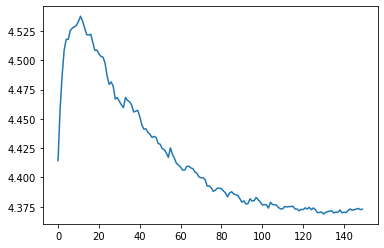

In [95]:
plt.plot(pd.concat(ev, axis = 1).mean())

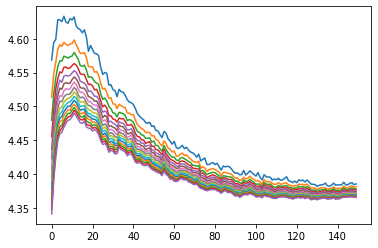

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ev)

In [47]:
evolution_of_ratings[10]

,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,...,top_61,top_62,top_63,top_64,top_65,top_66,top_67,top_68,top_69,top_70
uid_128088,4.650692,4.649161,4.616331,4.615441,4.596056,4.594352,4.589970,4.589406,4.588445,4.587890,...,4.506167,4.505651,4.504607,4.504598,4.503761,4.502584,4.502310,4.502257,4.502024,4.501986
uid_267455,4.305471,4.301026,4.297292,4.296194,4.285482,4.284172,4.276015,4.274782,4.272125,4.271817,...,4.213039,4.212140,4.212131,4.211586,4.208626,4.207814,4.207559,4.207558,4.207414,4.207317
uid_73381,4.349210,4.338031,4.336620,4.321699,4.321244,4.313539,4.307417,4.305100,4.303597,4.303392,...,4.253491,4.253299,4.249721,4.249629,4.248288,4.247994,4.246197,4.246163,4.245552,4.243743
uid_117628,4.204550,4.202176,4.196797,4.196415,4.185781,4.185253,4.183219,4.179440,4.178827,4.177018,...,4.145024,4.143894,4.143781,4.143696,4.142351,4.141925,4.141332,4.141132,4.141040,4.140790
uid_21453,4.257573,4.256428,4.242395,4.233850,4.227485,4.227279,4.225748,4.220630,4.216991,4.213280,...,4.174425,4.174275,4.174062,4.173525,4.173290,4.172800,4.172599,4.172269,4.172170,4.171809
uid_229622,4.290183,4.257799,4.254654,4.254363,4.251492,4.247464,4.247429,4.245629,4.244134,4.242157,...,4.202805,4.202561,4.202460,4.202309,4.202237,4.201444,4.201187,4.200155,4.199439,4.198274
uid_167368,4.812387,4.792214,4.775241,4.771976,4.770697,4.769690,4.767356,4.758998,4.754671,4.752541,...,4.694561,4.694387,4.693647,4.693459,4.692391,4.691842,4.691225,4.691085,4.690373,4.690299
uid_21772,4.286947,4.281706,4.278850,4.276237,4.272594,4.269352,4.268474,4.266694,4.265045,4.264333,...,4.217089,4.216939,4.216805,4.216358,4.215498,4.215206,4.214997,4.214248,4.213972,4.213722
uid_176555,4.235021,4.191612,4.186888,4.183321,4.178949,4.177466,4.175609,4.165580,4.164265,4.156556,...,4.103375,4.102600,4.101932,4.101908,4.100172,4.099363,4.098148,4.097881,4.097198,4.096393
uid_166868,3.249481,3.240295,3.238356,3.238142,3.236836,3.234656,3.232762,3.231254,3.231013,3.226904,...,3.174298,3.172656,3.172651,3.172456,3.172355,3.172276,3.171221,3.170952,3.170405,3.169114


In [86]:
results_movies.reset_index()

,level_0,level_1,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
0,epoch_0,uid_128088,1203,858,5618,215,1610,2064,3000,678,2019,55820,1234,3089,3507,1207,106100
1,epoch_0,uid_267455,1203,318,2019,527,1211,904,1617,50,1136,1276,4973,1198,1262,541,750
2,epoch_0,uid_73381,4973,1276,904,912,1204,1256,3730,7361,1203,3949,1250,1262,4848,1244,5971
3,epoch_0,uid_117628,1203,5618,904,2019,44555,2804,912,1617,356,1732,1262,2959,1193,2324,3911
4,epoch_0,uid_21453,260,296,527,1276,1210,1196,79132,318,904,2019,110,1198,899,4848,1291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,epoch_149,uid_182815,26078,4061,3661,65642,7773,59604,6822,3658,8266,6805,25927,6011,1612,37853,27478
14996,epoch_149,uid_254394,26078,59604,3658,8266,6805,25927,65642,37853,7773,95441,1612,154,95149,127178,6429
14997,epoch_149,uid_269446,77307,114060,26491,5619,7066,114847,1397,31689,42900,4151,73854,4338,2494,3776,16
14998,epoch_149,uid_146366,95149,26078,8366,5390,91978,3149,6442,95441,166534,7587,65642,6394,25927,7579,3661


In [34]:
n_epochs = 99
results_movies = pd.concat(evolution_of_movies, keys=['epoch_'+str(i) for i in range(n_epochs)])
results_ratings = pd.concat(evolution_of_ratings, keys=['epoch_'+str(i) for i in range(n_epochs)])
# results.to_csv('evolution_10_epochs.csv')

In [35]:
results_movies.to_csv('movie_evolution_99epochs_50users_sim_1000users_total_70mov.csv')
results_ratings.to_csv('rating_evolution_99epochs_50users_sim_1000users_total_70mov.csv')

In [62]:
# results.to_csv('evolution_400epochs_10users_sim_1000users_total_12mov.csv')

In [61]:
results

top_1  top_2   top_3  top_4  top_5   top_6  top_7  \
epoch_0   uid_128088     919    940   34405    899   2132    1233   4641   
          uid_267455     541   2571     318   1136   1203    1198   1193   
          uid_73381     1276    541     904    306   1203    1208    858   
          uid_117628    5291   5618    1222   1203    904     541    912   
          uid_21453      318   2959    1172   5952   1276    2019   2571   
...                      ...    ...     ...    ...    ...     ...    ...   
epoch_399 uid_229622     999   7781    2332   8939    409   25996   5577   
          uid_167368    8939   5577   94405  25996  91474    3026   5603   
          uid_21772      999   2332    7781  82167   8939  150262  88911   
          uid_176555    2332  25996  150262  88911  82167  105769   8939   
          uid_166868  105769   5577    6280   5288   6584    7704  82167   

                       top_8  top_9  top_10  top_11  top_12  
epoch_0   uid_128088    5618    913    1204     215    1260  
          uid_267455     306    858    1250      50    2019  
          uid_73381       50   2019     908    1207    1247  
          uid_117628    2019    910     908   44555    1204  
          uid_21453     1203   1258    1237     260    4993  
...                      ...    ...     ...     ...     ...  
epoch_399 uid_229622   74668  88911   47124    6280  156371  
          uid_167368  112946   7704   55261  120635   75813  
          uid_21772     6280  74668   25996  156371    6419  
          uid_176555    5603   5577    3026    5288   59429  
          uid_166868   93831   3026    4893  150262    6419  

[4000 rows x 12 columns]

In [38]:
results

top_1   top_2  top_3   top_4   top_5   top_6   top_7  \
epoch_0   uid_128088    947    6170   3134    1250   86504    5291     952   
          uid_267455  86504    3730   3022     952    4312     665  104069   
          uid_73381   86504    4312    665    1446    3134    3022    5291   
          uid_117628    947    3134   5291    3730    1226  142488     952   
          uid_21453   86504    2732   3134    4312     947    3022    2905   
...                     ...     ...    ...     ...     ...     ...     ...   
epoch_199 uid_229622  45210   96110   5004  157270    2442    3950  136447   
          uid_167368   5004  157270  51088    3950   57655   59995    1695   
          uid_21772   96110   45210   5004  157270  136447    4126    3950   
          uid_176555   5004  157270   4126    3950   51088   86644  102194   
          uid_166868  96110   45210   5004    2442  157270   51088    5625   

                       top_8  top_9  top_10  top_11  top_12  top_13  top_14  \
epoch_0   uid_128088     935  86347    1929     950     665     942     953   
          uid_267455    3435   5291     318    6170    3134    1446    1203   
          uid_73381   162414    935  100714    2843    3089    8370   44555   
          uid_117628     665   1446    4312    3022   79357    2843    4902   
          uid_21453      935    665    1207    3435    3089    2360     945   
...                      ...    ...     ...     ...     ...     ...     ...   
epoch_199 uid_229622   51088   4126   96079   86644  102194   57655   65596   
          uid_167368    6779  94677   53189  168252   42418   25744   32587   
          uid_21772    51088  86644  102194   57655   65596    3658   59995   
          uid_176555   57655  59995   25741    1695    6306   94677    6779   
          uid_166868    3950   3363  136447   96079    4126   86644  102194   

                      top_15  
epoch_0   uid_128088    2920  
          uid_267455    1211  
          uid_73381     2905  
          uid_117628    5618  
          uid_21453     3730  
...                      ...  
epoch_199 uid_229622    3658  
          uid_167368    2138  
          uid_21772    25741  
          uid_176555   53189  
          uid_166868   57655  

[2000 rows x 15 columns]

In [19]:
# movielens = movielens_shorter

In [20]:
# popular_iids = movielens_short.iid.value_counts()[movielens_short.iid.value_counts()>1000].index

In [21]:
# movielens_short[movielens_short.iid.isin(popular_iids)].shape

In [54]:
# movielens_upd = movielens.append(pd.DataFrame([[50, 52, 5.0]], columns = ['uid', 'iid', 'rating'])).reset_index(drop=True)

In [24]:
# movielens_upd

In [36]:
# movielens.shape, movielens_upd.shape

((2741736, 3), (2741737, 3))

In [55]:
# data = surprise.Dataset.load_from_df(movielens_upd, reader)

In [56]:
# loaded_model.trainset = data.build_full_trainset()

In [57]:
# loaded_model.l = 1

In [58]:
# loaded_model.verbose = True

In [25]:
# loaded_model.sgd(loaded_model.trainset)

In [42]:
# %%time
# data = surprise.Dataset.load_from_df(movielens_upd, reader)
# alg = surprise.SVDpp()
# output = alg.fit(data.build_full_trainset())

CPU times: user 28min 7s, sys: 279 ms, total: 28min 7s
Wall time: 28min 8s


In [29]:
# filename = 'finalized_model.sav'
# # pickle.dump(alg, open(filename, 'wb'))

In [30]:
# loaded_model = pickle.load(open(filename, 'rb'))

In [31]:
# loaded_model.predict(uid = '50', iid = '52').est

In [208]:
%%time
data = surprise.Dataset.load_from_df(movielens_similar, reader)
alg = surprise.SVDpp(verbose=True)
output = alg.fit(data.build_full_trainset())

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
CPU times: user 4.57 s, sys: 4.03 ms, total: 4.57 s
Wall time: 4.56 s
